# Project: Developing Predictive Models using Customer Churn Data 

The goal of the project is to reduce customer churn, increase customer retention, and identify factors influencing churn to improve customer satisfaction.

## Data
I will use Telco Customer Churn dataset. The dataset comprises 7,043 observations and 21 attributes. It is rich in categorical data (85.71% of attributes), including customer demographics, services availed (like multiple lines, internet service, security), and account information (contract type, billing method). It also features tenure, monthly charges, and a churn indicator. This dataset is a good candidate for churn analysis, offering insights into customer behavior and retention. The comprehensive set of features makes it suitable for both classification (predicting churn) and regression tasks (analyzing continuous variables like charges). 

In this project I will develop a classification model to predict customer churn.

## Importing Required Modules and Loading Data

In [1]:
# Importing required libraries
import sys
sys.executable

'C:\\Users\\shibb\\git_ml_projects\\churnenv\\Scripts\\python.exe'

In [2]:
import pandas as pd
import numpy as np


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
# from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization


from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             roc_curve, 
                             auc, 
                             precision_recall_curve, 
                             average_precision_score, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay, 
                             recall_score, 
                             precision_score, 
                             f1_score)
from sklearn.compose import make_column_transformer
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, MinMaxScaler, StandardScaler

from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import chi2_contingency

from imblearn.over_sampling import SMOTE # Over sampling
from imblearn.under_sampling import RandomUnderSampler # Under sampling
from imblearn.combine import SMOTETomek  #combined under and oversampling

import matplotlib.pyplot as pltpredict
from matplotlib import pyplot as plt

import seaborn as sns 

import phik
from phik.report import plot_correlation_matrix
from phik import report

from prettytable import PrettyTable

import re

import warnings
warnings.filterwarnings("ignore")
# !pip install imbalanced-learn


In [3]:
pd.set_option('display.max_columns', None)

In [4]:
# Load the data
df = pd.read_csv('customer_churn.csv')

## Exploratory Data Analysis

In [5]:
# Making a copy of the data for the analysis
df1 = df.copy() 

In [6]:
df1.shape

(7043, 21)

There are 7043 data points and 21 features in the data set

In [7]:
df1.head(5)

customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No          No          No              No  Month-to-month   
1              Yes          No          No              No        One year   
2               No          No          No              No  Month-to-month   
3              Yes         Yes          No              No        One year   
4               No          No          No              No  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  \
0              Yes           Electronic check           29.85        29.85   
1               No               Mailed check           56.95       1889.5   
2              Yes               Mailed check           53.85       108.15   
3               No  Bank transfer (automatic)           42.30      1840.75   
4              Yes           Electronic check           70.70       151.65   

  Churn  
0    No  
1    No  
2   Yes  
3    No  
4   Yes

In [8]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


The features are diverse covering demographic, contractual, services, and charges information. We will use 'Churn' as our target variable.

There are 18 categorical and 3 numeric variables as shown above. However, 'TotalCharges' variable should be a numeric variable that we need to convert.

'tenure' is an ordinal categorical feature. We also need to convert it accordingly.

'SeniorCitizen' will be converted to a nominal categorical variable.

We will not need 'customerID' variable for our analysis and will drop it. 

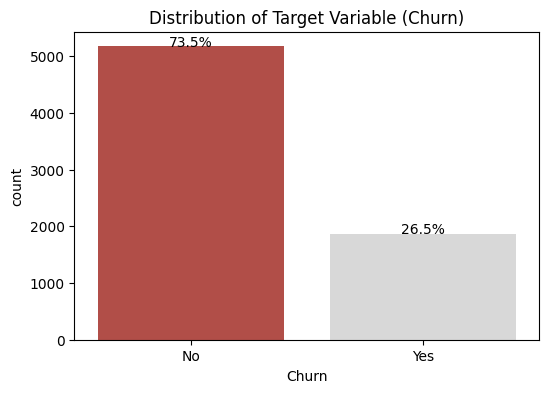

In [9]:
# Plot displaying the distribution of the target variable

# Defining the plot
plt.figure(figsize=(6, 4))  

# Counting the occurrences of each class
class_counts = df1['Churn'].value_counts()

# Plotting the count plot with annotations
ax = sns.countplot(x='Churn', data=df1, palette=['#c33e36', '#d8d8d8'])  

# Annotating the plot with percentages
total = len(df1['Churn'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 3
    ax.annotate(percentage, (x, y), ha='center')

plt.title('Distribution of Target Variable (Churn)')
plt.show()

Churn rate is 26.5% and no-churn 73.5%. The target variable is highly imbalanced and the majority class might dominate the outcome of the model. To address this issue, we will apply resampling methods in later sections.

In [10]:
# Dropinng customerID as it will not be used as a predictor feature
df1.drop("customerID", axis=1, inplace = True)

In [11]:
# Converting TotalCharges-which is currently an object data type to a float data type
df1['TotalCharges'] = pd.to_numeric(df1['TotalCharges'], errors='coerce')
df1['TotalCharges'].isna().sum()

11

After converting, we find there are missing values in 'TotalCharges'.

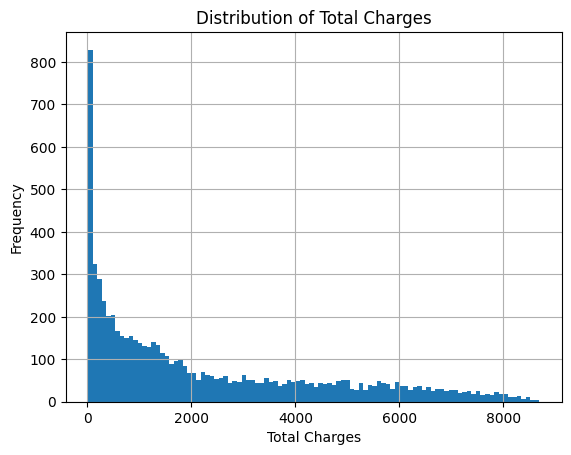

In [12]:
# Drawing a histogram of total charges to determine the impute method for filling in missing values

df1['TotalCharges'].hist(bins=100)
plt.title('Distribution of Total Charges')
plt.xlabel('Total Charges')
plt.ylabel('Frequency')
plt.show()

We will impute the missing values with the median, as the distribution of this feature is right skewed. A mean value will be influenced by higher costs and outliers, so  we will not use mean.

In [13]:
df1.TotalCharges = df1.TotalCharges.astype(float)
df1['TotalCharges'].fillna(df1['TotalCharges'].median(), inplace=True)

Tenure is an ordinal categorical feature. We will convert it accordingly.

In [14]:
df1['tenure'] = df1['tenure'].astype('object')

Senior citizen is a nominal categorical variable, and we will convert it accordingly

In [15]:
df1['SeniorCitizen'] = df1['SeniorCitizen'].astype('object')

In [16]:
# After the conversions, the final view of data types are as below:-
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   object 
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


To improve readability and ease of analysis, we will convert column names to lower cases seperated with underscrore for multiword names

In [17]:
def clean_column_name(col):
    # Using regular expression to insert underscore before capital letters (except at the beginning)
    cleaned_col = re.sub(r'([a-z0-9])([A-Z])', r'\1_\2', col)
    # Converting to lowercase
    return cleaned_col.lower()

df1.columns = [clean_column_name(col) for col in df1.columns]

We will also convert our target variable to binary numeric, 1 for Yes churn class, and 0 for No churn class.

In [18]:
df1.churn = df1.churn.apply(lambda x: 1 if x == 'Yes' else 0)

In [19]:
# Now let's view the sample of the data set to confirm everything is coded properly
df1.sample(5)

gender senior_citizen partner dependents tenure phone_service  \
437     Male              0     Yes        Yes     72           Yes   
3455    Male              0      No         No      1           Yes   
6962  Female              1     Yes         No     27           Yes   
6336    Male              0     Yes        Yes     57           Yes   
2137    Male              0     Yes        Yes     12           Yes   

     multiple_lines internet_service      online_security  \
437             Yes      Fiber optic                  Yes   
3455             No      Fiber optic                   No   
6962             No      Fiber optic                  Yes   
6336            Yes      Fiber optic                   No   
2137            Yes               No  No internet service   

            online_backup    device_protection         tech_support  \
437                   Yes                  Yes                  Yes   
3455                   No                   No                   No   
6962                   No                  Yes                   No   
6336                   No                   No                   No   
2137  No internet service  No internet service  No internet service   

             streaming_tv     streaming_movies        contract  \
437                   Yes                  Yes        Two year   
3455                  Yes                  Yes  Month-to-month   
6962                  Yes                  Yes  Month-to-month   
6336                   No                   No  Month-to-month   
2137  No internet service  No internet service        Two year   

     paperless_billing             payment_method  monthly_charges  \
437                Yes    Credit card (automatic)           114.05   
3455               Yes           Electronic check            90.55   
6962               Yes           Electronic check           101.25   
6336               Yes           Electronic check            74.30   
2137               Yes  Bank transfer (automatic)            25.40   

      total_charges  churn  
437         8468.20      0  
3455          90.55      1  
6962        2754.45      1  
6336        4018.35      0  
2137         313.00      0

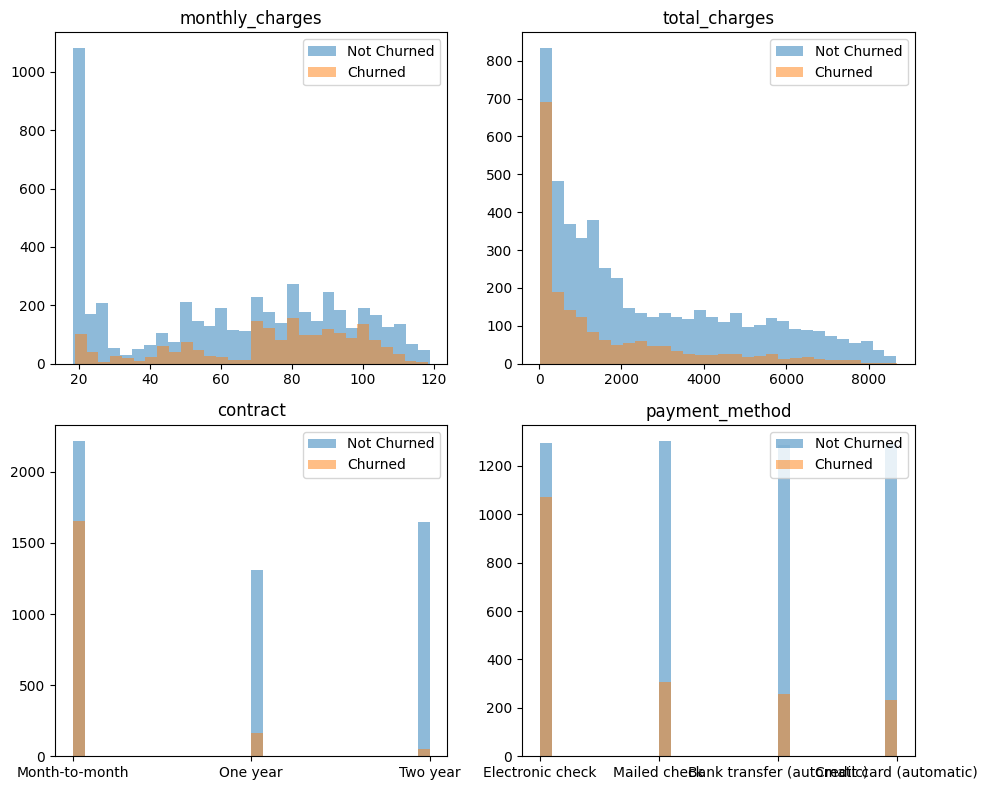

In [20]:
# Plotting the payment-related columns to analyze their relations
payment_col = ['monthly_charges', 'total_charges', 'contract', 'payment_method']

# Creating subplots
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

# Iterating over payment columns
for i, cat_col in enumerate(payment_col):
    # Iterating over churn values
    for churn_value in df1['churn'].unique():
        data_subset = df1[df1['churn'] == churn_value][cat_col]
        axs[i].hist(data_subset, bins=30, alpha=0.5, label=f'Churn: {churn_value}')

    axs[i].set_title(cat_col)
    axs[i].legend(['Not Churned', 'Churned'])

# Adjusting layout and display plot
plt.tight_layout()
plt.show()

Churned customers typically have monthly charges between $70-$105. Most of the customers churn at the lower levels of total charges-showing their sensitivity to cost and unwillingness to continue longer with the company. This was proven in contract plot where churned customers concentrate in monthly contracts with almost immaterial levels in one year and two year contracts. Most of the churned customers are the users of electronic checks as far as payment methods are concerned.

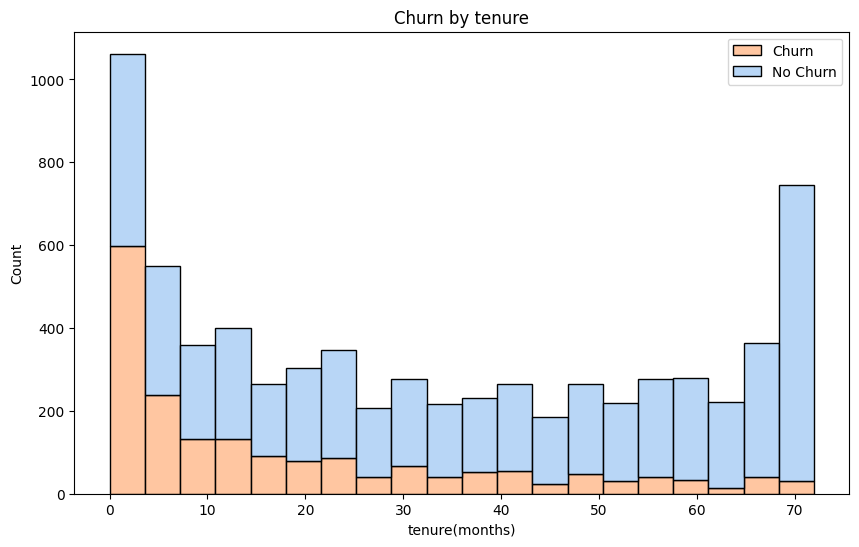

In [21]:
# Ploting the distribution of the target variable by tenure

plt.figure(figsize=(10, 6))
sns.histplot(df1, x=df1.tenure, hue=df1['churn'], bins=20, multiple = 'stack', palette='pastel')
plt.xlabel('tenure(months)')
plt.ylabel('Count')
plt.title('Churn by tenure');
plt.legend(['Churn', 'No Churn'])

Churned customers are concentrated at the lower end of the tenure. This is in agreement with contract type which shows most churners have month-to-month contracts.

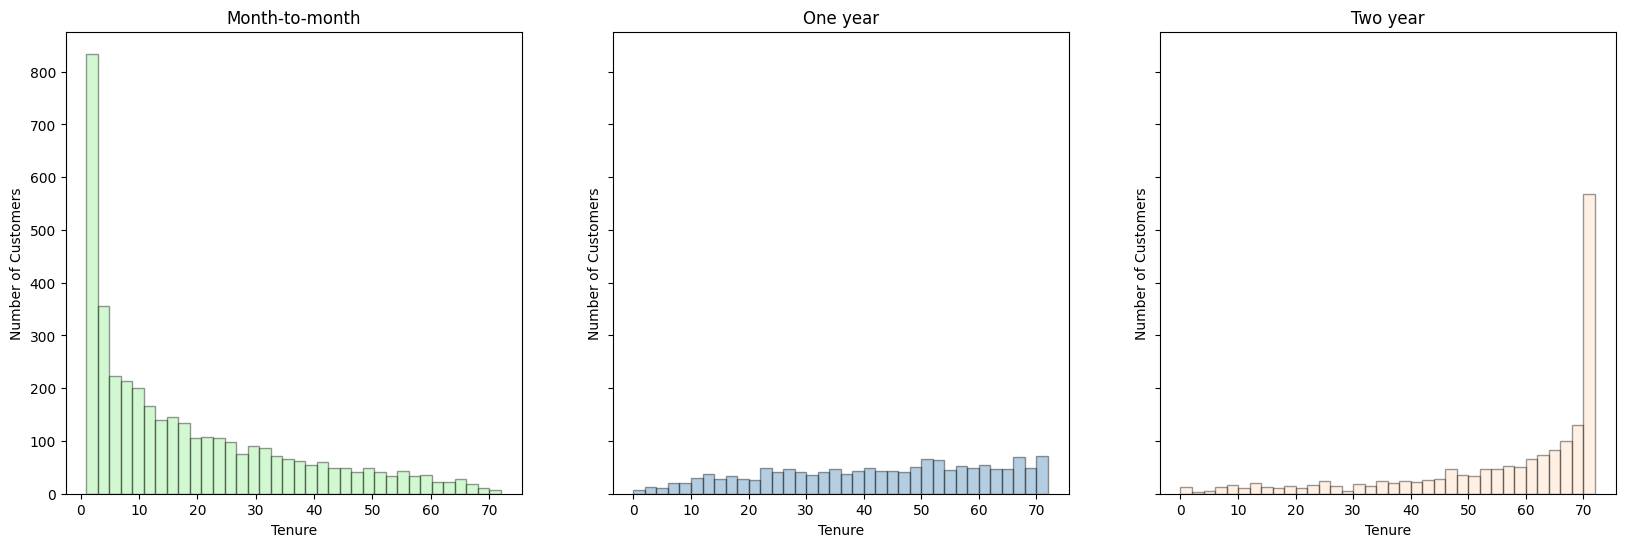

In [22]:
# Plotting the tenure in terms of payment type/((contract)).

fig, axs = plt.subplots(1,3, sharey=True, figsize=(20,6)) # same as nrows=1, ncols=3

contract_types = ['Month-to-month', 'One year', 'Two year']
colors = ['lightgreen', 'steelblue', 'peachpuff']

for i, contract_type in enumerate(contract_types):
    ax = axs[i]
    ax = sns.distplot(df1[df1['contract']==contract_type]['tenure'],
    hist=True, 
    kde=False,
    bins=int(180/5), 
    color=colors[i],
    hist_kws={'edgecolor':'black'},
    kde_kws={'linewidth': 4},
    ax=ax,)
    ax.set_ylabel('Number of Customers')
    ax.set_xlabel('Tenure')
    ax.set_title(contract_type)

Customers having long term contracts stay with the company much longer than customers having monthly contracts-who ends the contract much sooner.

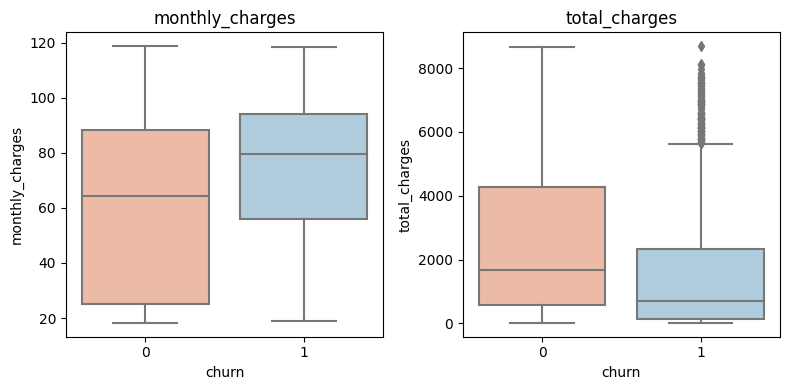

In [23]:
# Creating box plots for numeric features.
num_labels = ['monthly_charges', 'total_charges']

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

for i, num_col in enumerate(num_labels):
    ax = axs[i]  
    sns.boxplot(
        x=df1['churn'], 
        y=num_col, 
        data=df1, 
        palette='RdBu', 
        ax=ax,  
    )
    ax.set_title(num_col)

plt.tight_layout()
plt.show()

Median monthly charges are materially higher for churners compared to non-churners. This is an area the company might look into, as the competitors can easily atttract this secton of customers leading to higher churn. This might as well be one of the root causes of high churn. 

As the customers churn faster, total charges do not accumulate for this class(except for a few outliers).

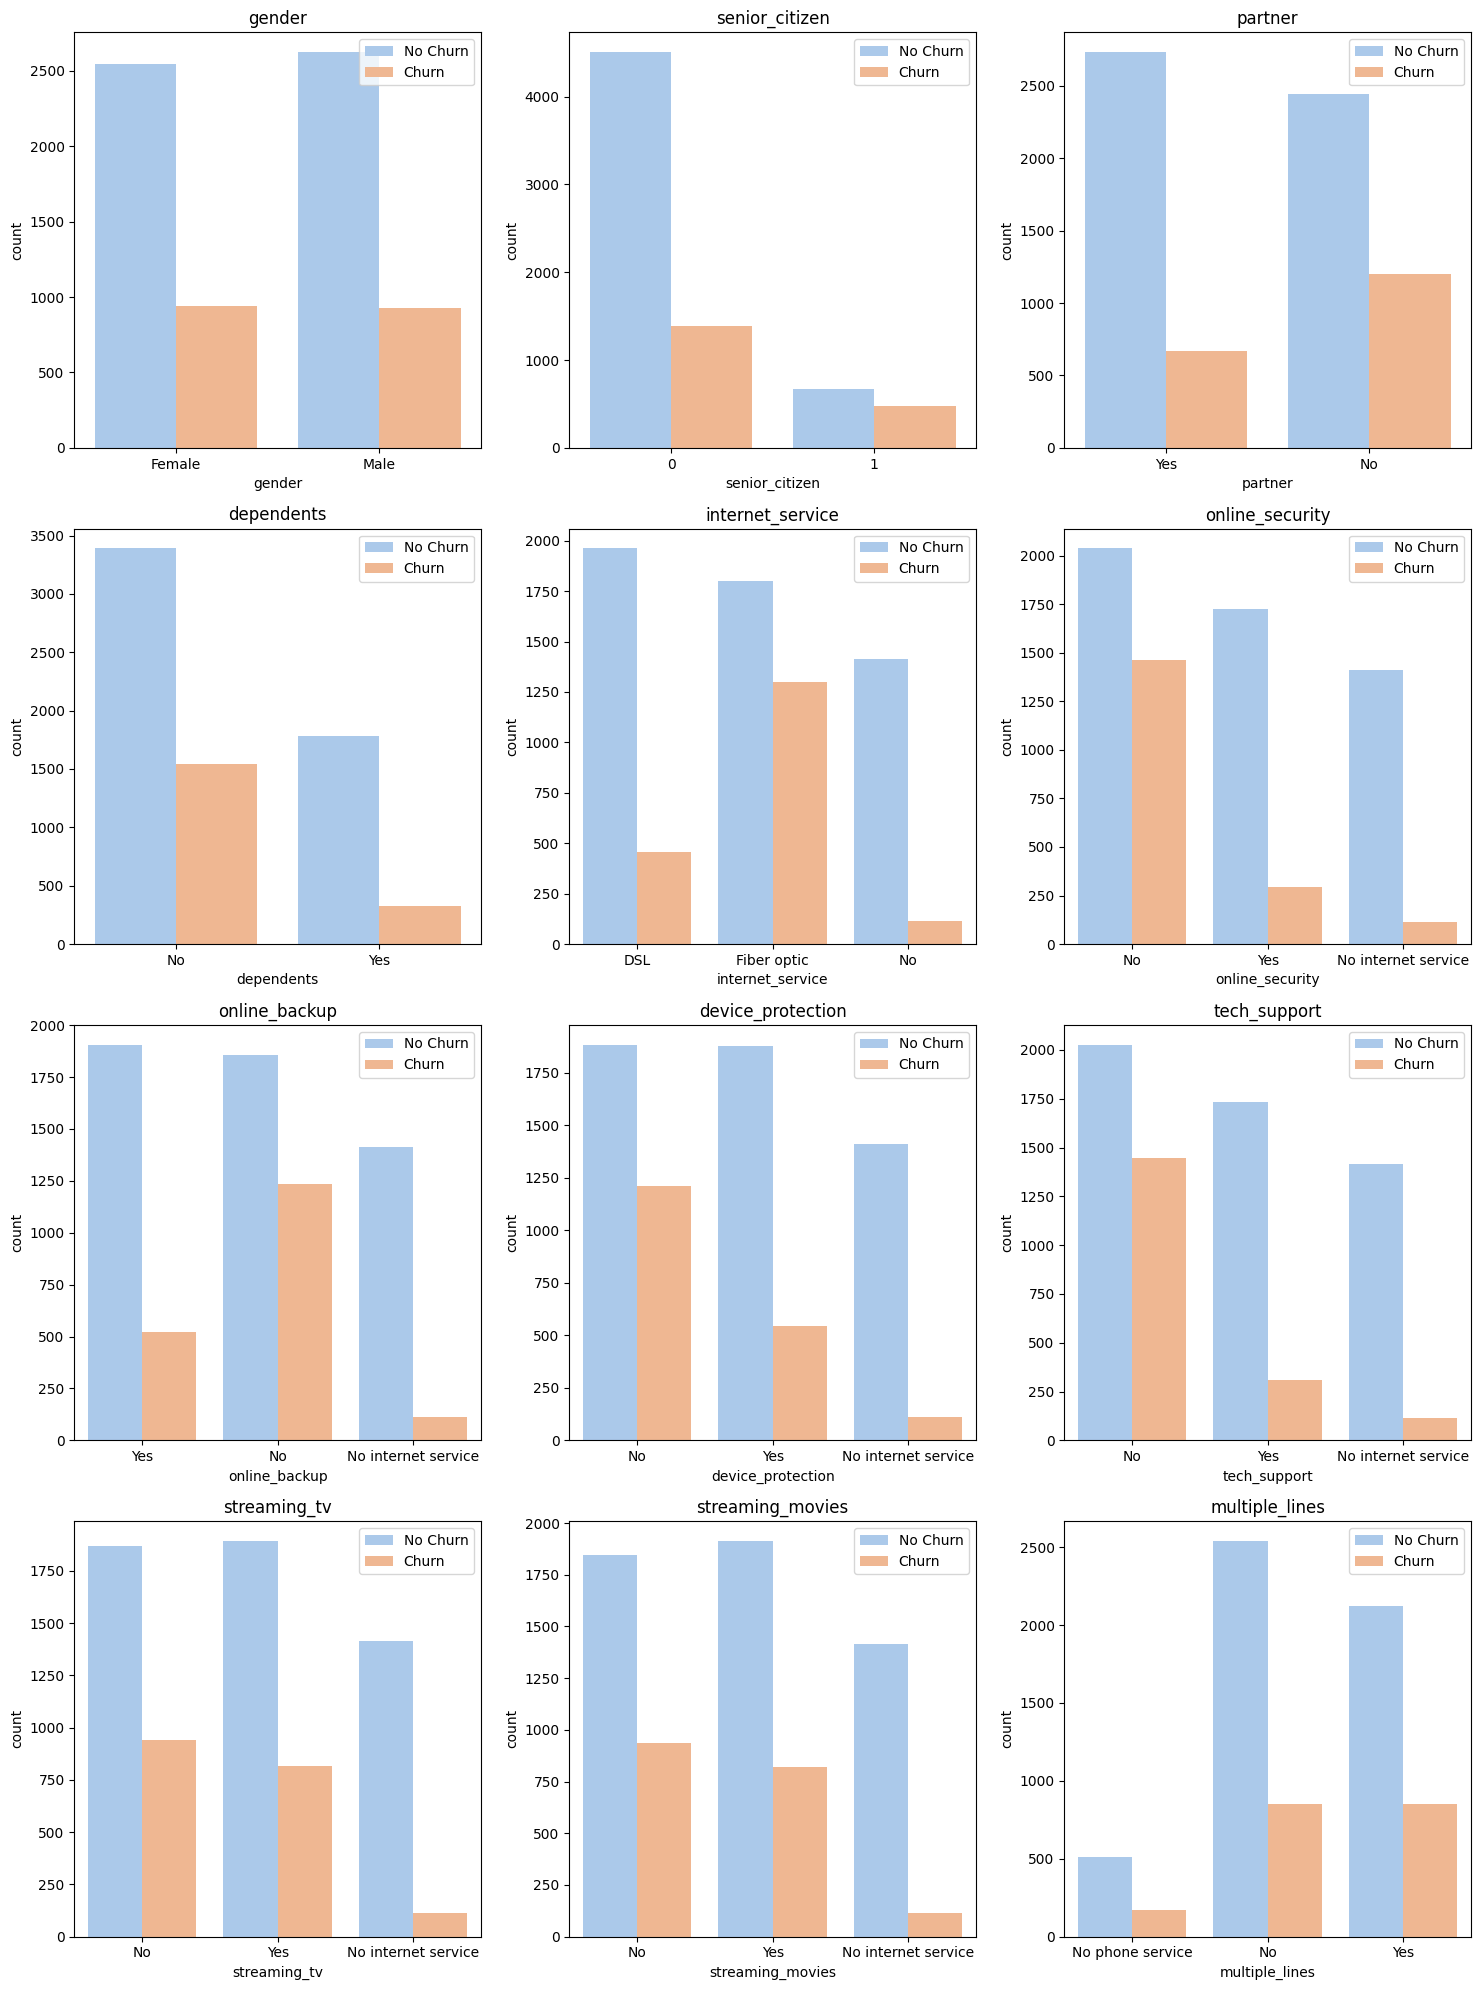

In [24]:
# Ploting the remaining features in terms of the target variable
personal_col = [
    'gender', 'senior_citizen', 'partner', 'dependents', 
    'internet_service', 'online_security', 'online_backup',
    'device_protection', 'tech_support', 'streaming_tv',
    'streaming_movies', 'multiple_lines'
]

fig, axs = plt.subplots(4, 3, figsize=(15, 20))
axs = axs.flatten()

for i, col in enumerate(personal_col):
    sns.countplot(
        data=df1, x=col,
        hue='churn',
        palette='pastel',
        ax=axs[i]
    )

    axs[i].set_title(col)
    axs[i].legend(['No Churn', 'Churn'])

plt.tight_layout()
plt.show()

Of the demographic categorical variables, gender is mostly neutral to churn, senior citizens tend to have less churn compared to younger citizens. Having no partner tends to churn much higher compared to customers having partners. Customers having dependants tend less to churn compared to customers with no dependants.

Of the services categorical variables, customers using fiber optic churn much faster. This might indicate high competition in this field, as more and more companies are entering this market offering affordable prices to attract new customers.

Customers who do not have online security churn much faster. The company may look into this as cyber security is becoming a growing concern which might encourage customers to find better options.

Customers having no online backup, no device protection and no tech support have higher churns.

Customers who do not stream tv or movies churn slightly higher. Having multiple lines or not seems to have no material impact on churn.

Customers having no internet service and no phone service tend to churn much lower across all categories where they are present.

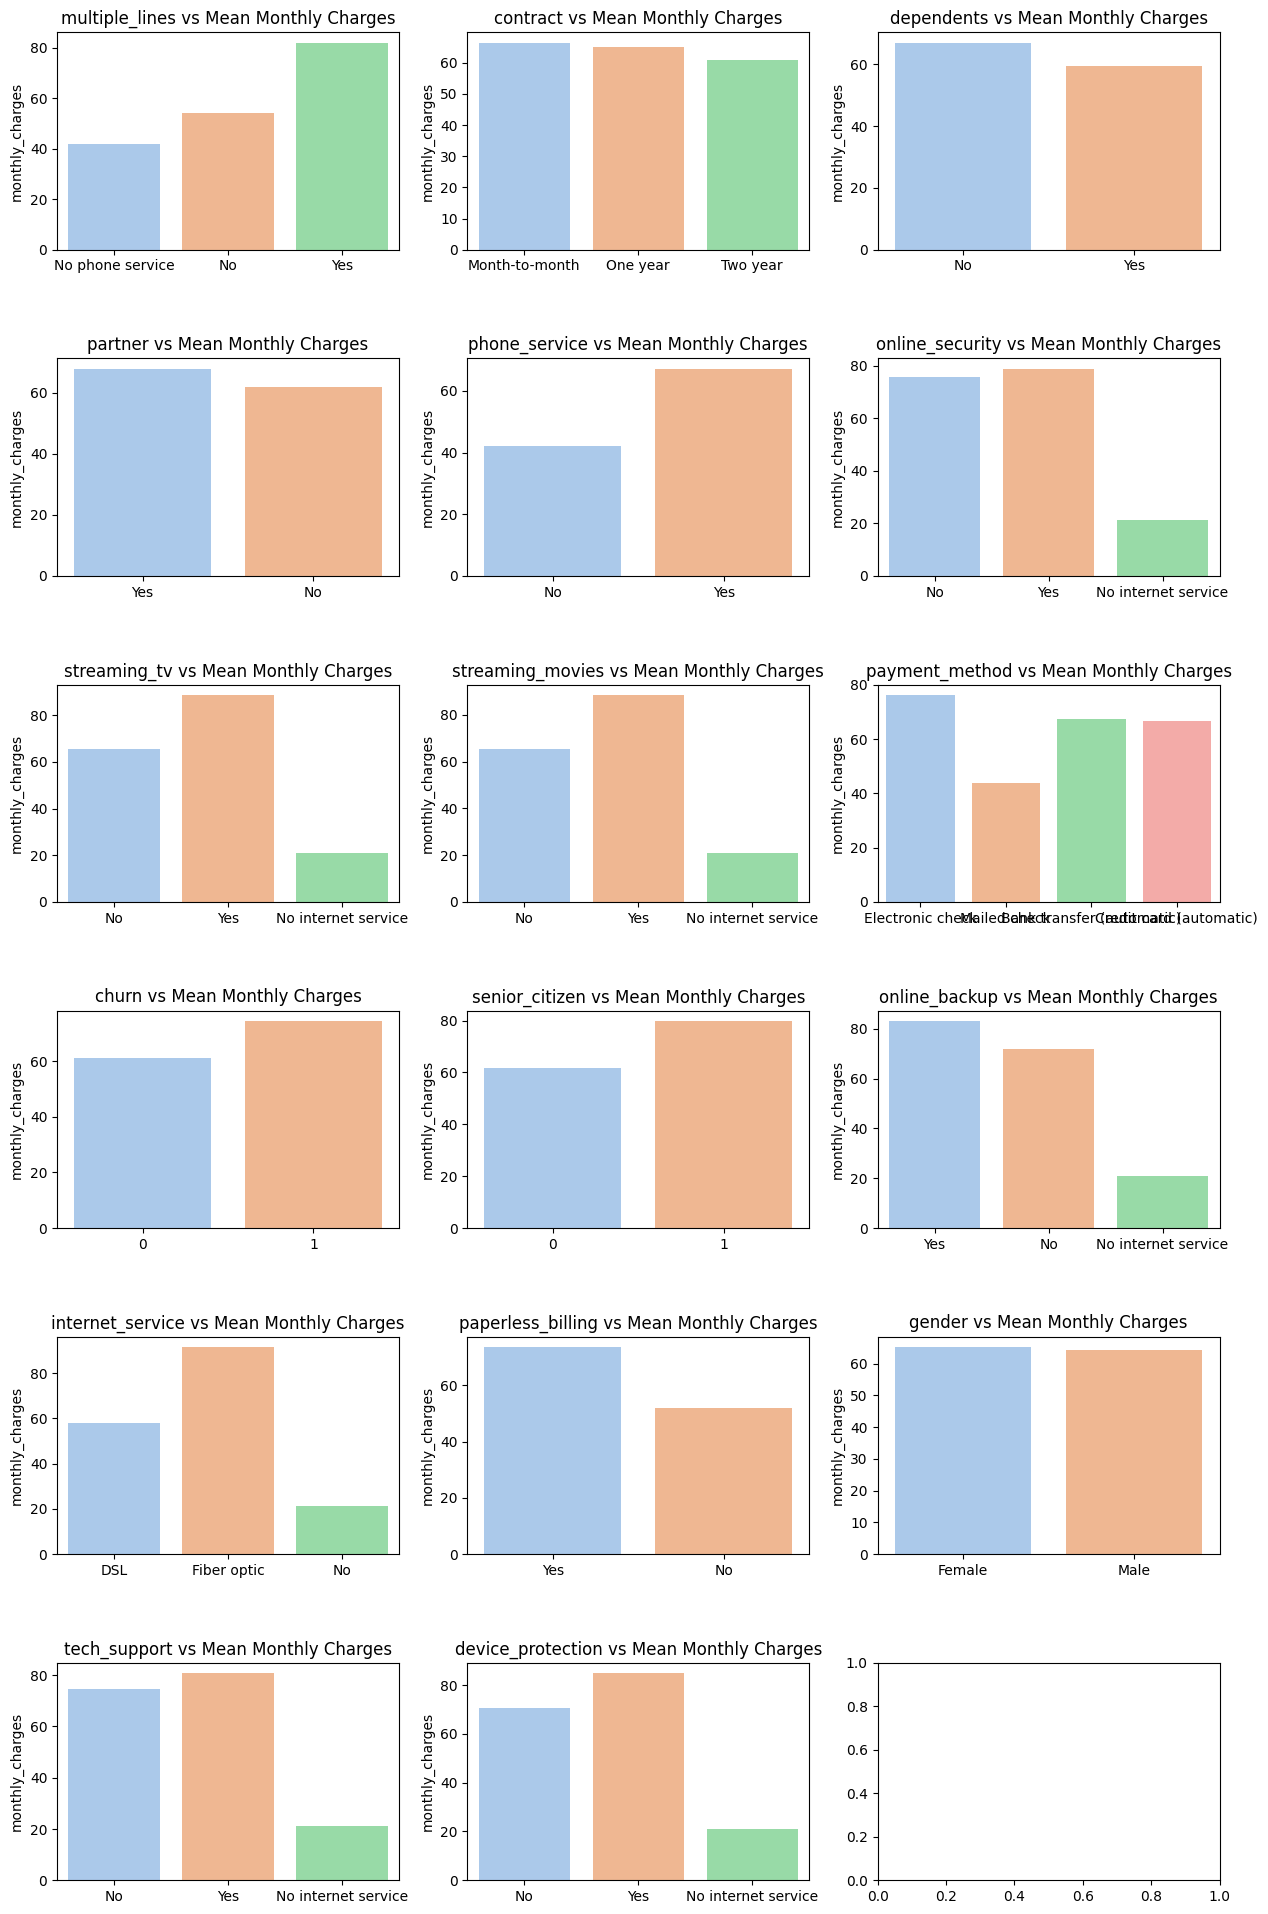

In [25]:
# Plotting all features in terms of monthly charges to see any patterns
cols = list(set(df1.columns) - set(['monthly_charges', 'total_charges', 'customer_id', 'tenure']))
num_cols = 3
num_rows = (len(cols) + num_cols - 1) // num_cols  
fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))
fig.subplots_adjust(hspace=0.5)

for i, cat_col in enumerate(cols):
    row_idx = i // num_cols
    col_idx = i % num_cols
    
    sns.barplot(x=cat_col, y='monthly_charges', data=df1, ax=axs[row_idx, col_idx], palette='pastel', ci=None)
    axs[row_idx, col_idx].set_xlabel('')
    axs[row_idx, col_idx].set_title(f'{cat_col} vs Mean Monthly Charges')

plt.show()

Analysis of mean monthly charges per feature types demonstrate that monthly charges are generally higher for customers enjoying more services including streaming tv, having fiber optic, having phone service, having multiple lines, etc. However, paperless billing should cost less compared to by-post billing.

Mean monthly charges of the churn class are higher compared to the non-churn class, which implies that customers who tend to churn also enjoy more services, but they might want to have those services at competitive prices.

Mean monthly charges gradually decline with increasing contract terms. The company may promote longer-term contracts to churn class to increase retention, as this will offer better prices for the customers who are cost sensitive.

In [26]:
# We will now identify a few traits of a customer who generally wants to churn
def get_churn_info(
    data: pd.DataFrame,
    cat_col: list,
    num_col: list,
) -> pd.DataFrame:

    result = pd.DataFrame()
    
    for col in cat_col:
        result.loc[col, 'value'] = data[col].value_counts().index[0]

    for num in num_col:
        result.loc[num, 'value'] = round(data[num].mean())
    
    return result

In [27]:
get_churn_info(
    data = df1[df1.churn == 1],
    cat_col = ['contract', 'payment_method', 'internet_service', 'multiple_lines', 'tenure'],
    num_col = ['monthly_charges', 'total_charges']
)

value
contract            Month-to-month
payment_method    Electronic check
internet_service       Fiber optic
multiple_lines                 Yes
tenure                           1
monthly_charges                 74
total_charges                 1532

The table above shows a high level profile of a customer who usually churn. This agrees with our analysis before. Churners have mostly monthly contracts, They use more services including electronic checks, fibre optics, multiple lines. They belong to lower tenure, lower total charges and higher monthly charges.

##  Feature Engineering

In [28]:
# We will create a few new features and see their predictive powers

# Contract Length in Months
contract_mapping = {'Month-to-month': 1, 'One year': 12, 'Two year': 24}
df1['contract_length_months'] = df1['contract'].map(contract_mapping).astype(object)

# Monthly Charges to Total Charges Ratio
df1['monthly_to_total_ratio'] = df1['monthly_charges'] / df1['total_charges'].astype(int)

# Interaction Features between tenure and monthly charges
df1['tenure_monthly_charges_interaction'] = df1['tenure'] * df1['monthly_charges'].astype(int)

In [29]:
df1.sample(2)

gender senior_citizen partner dependents tenure phone_service  \
4021  Female              0     Yes        Yes      1           Yes   
3572  Female              1      No         No     32           Yes   

     multiple_lines internet_service      online_security  \
4021             No               No  No internet service   
3572             No      Fiber optic                   No   

            online_backup    device_protection         tech_support  \
4021  No internet service  No internet service  No internet service   
3572                   No                   No                   No   

             streaming_tv     streaming_movies        contract  \
4021  No internet service  No internet service  Month-to-month   
3572                   No                  Yes  Month-to-month   

     paperless_billing    payment_method  monthly_charges  total_charges  \
4021               Yes      Mailed check             20.5           20.5   
3572               Yes  Electronic check             79.5         2665.0   

      churn contract_length_months  monthly_to_total_ratio  \
4021      1                      1                1.025000   
3572      0                      1                0.029831   

     tenure_monthly_charges_interaction  
4021                                 20  
3572                               2528

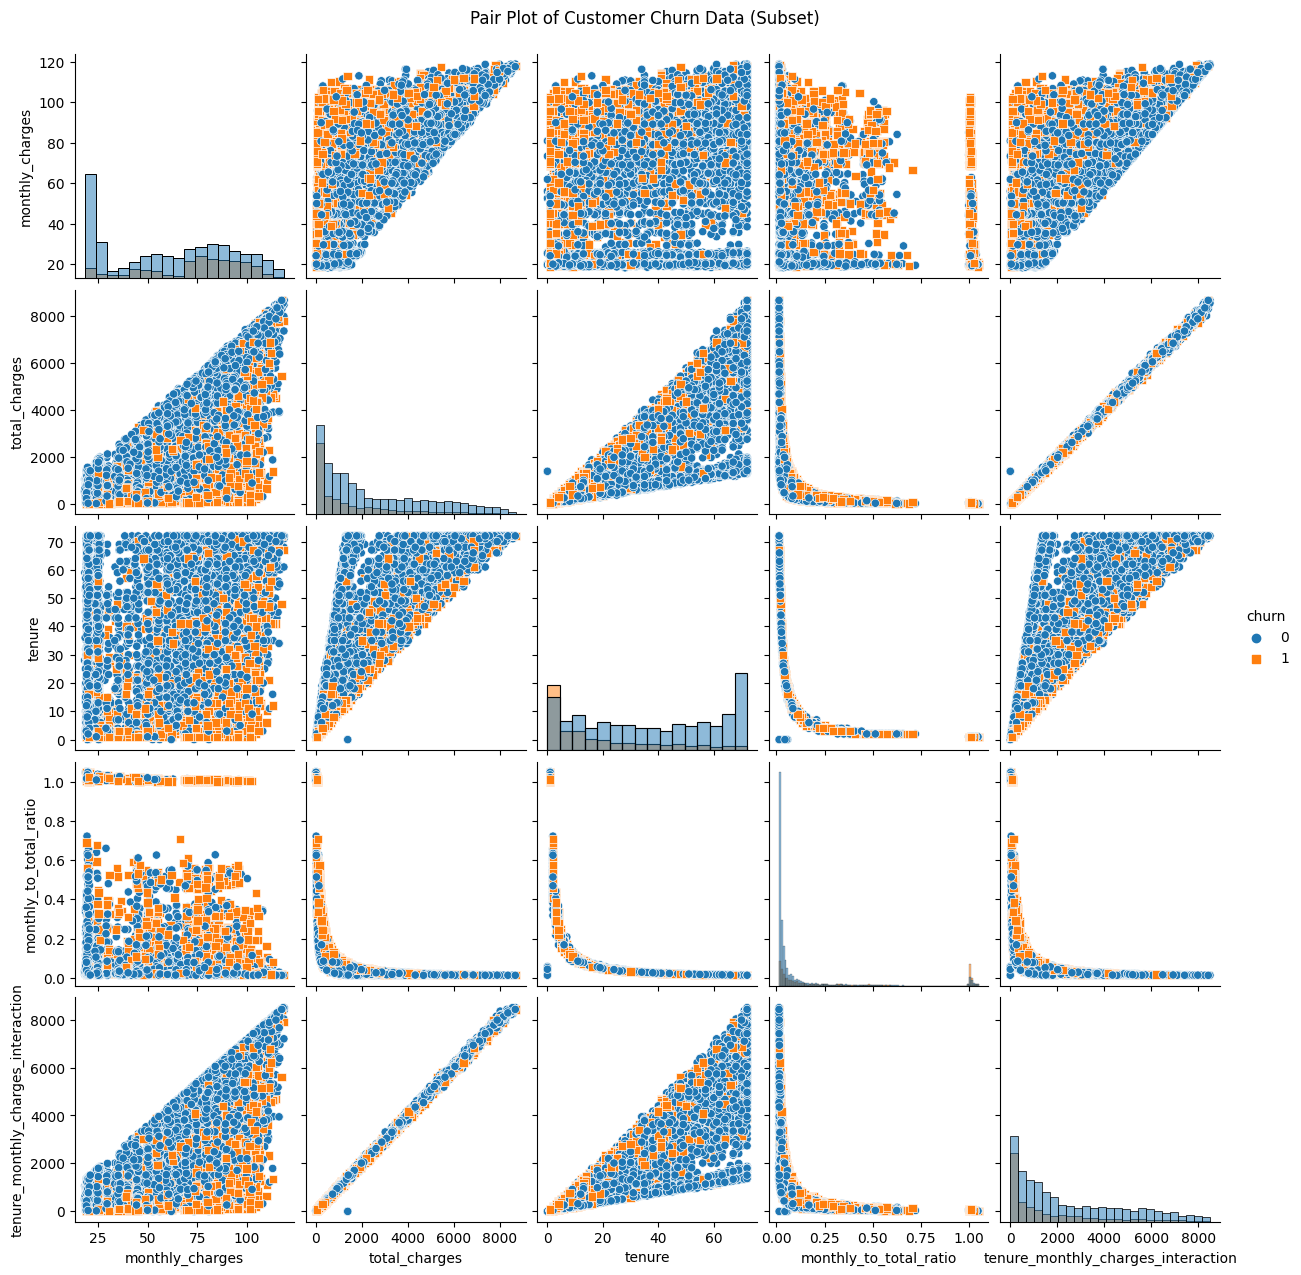

In [30]:
# We will now create a pair plot for the numeric variables to understand the distribution and relationships of variables. 

# Selecting a subset of numeric columns
subset_numeric_columns = ['monthly_charges', 'total_charges', 'tenure', 'monthly_to_total_ratio', 'tenure_monthly_charges_interaction' ]

# Adding the target variable 'churn' to the selected columns
selected_columns = subset_numeric_columns + ['churn']

# Creating the pair plot with the subset of numeric variables
sns.pairplot(df1[selected_columns], hue='churn', markers=['o', 's'], diag_kind='hist', height=2.5)
plt.suptitle('Pair Plot of Customer Churn Data (Subset)', y=1.02)
plt.show()

The scatter plots for monthly_charges, total_charges, monthly_to_total_ratio, and interaction features are right skewed-which indicates that a substantial portion of customers is associated with lower-cost plans or services and a smaller portion has higher-cost plans.

total_charges and tenure_monthly_charges_interaction show a high correlation. We will look into this in the sections ahead.

monthly_to_total_charges ratio sharply falls as total charges start increasing showing the sensitivity of the customers who tend to churn to higher total costs. The ratio becomes stable with higher and higher total charges-where customers are mostly non-churners. The same pattern is observed between the onthly_to_total_charges ratio and tenure. Churners stay for a short duration compared to non-churners.

## Correlation Analysis
We will build a correlation matrix and analyze the collinearity of the features.

We will use the phik_matrix function for categorical variables, and Pearson correlation for numeric variables.

In [31]:
df1.isnull().sum()

gender                                0
senior_citizen                        0
partner                               0
dependents                            0
tenure                                0
phone_service                         0
multiple_lines                        0
internet_service                      0
online_security                       0
online_backup                         0
device_protection                     0
tech_support                          0
streaming_tv                          0
streaming_movies                      0
contract                              0
paperless_billing                     0
payment_method                        0
monthly_charges                       0
total_charges                         0
churn                                 0
contract_length_months                0
monthly_to_total_ratio                0
tenure_monthly_charges_interaction    0
dtype: int64

In [32]:
# Correlation matrix for categorical variables

# Putting together quantitative features into the variable 'interval_cols'.
interval_cols = ['monthly_charges', 'total_charges', 'monthly_to_total_ratio', 'tenure_monthly_charges_interaction' ]

# Using the phik_matrix function from the phik library to calculate the Phi-K correlation matrix.
df1_cat = df1[df1.columns.difference(interval_cols)]
corr_matrix = df1_cat.phik_matrix(njobs=1)
# corr_matrix 
corr_matrix.round(2)

interval columns not set, guessing: ['churn']


churn  contract  contract_length_months  dependents  \
churn                    1.00      0.25                    0.25        0.25   
contract                 0.25      1.00                    1.00        0.15   
contract_length_months   0.25      1.00                    1.00        0.15   
dependents               0.25      0.15                    0.15        1.00   
device_protection        0.17      0.63                    0.63        0.09   
gender                   0.00      0.00                    0.00        0.00   
internet_service         0.20      0.51                    0.51        0.11   
multiple_lines           0.02      0.24                    0.24        0.01   
online_backup            0.18      0.58                    0.58        0.10   
online_security          0.21      0.64                    0.64        0.12   
paperless_billing        0.30      0.11                    0.11        0.17   
partner                  0.23      0.18                    0.18        0.65   
payment_method           0.45      0.28                    0.28        0.22   
phone_service            0.00      0.00                    0.00        0.00   
senior_citizen           0.23      0.09                    0.09        0.32   
streaming_movies         0.14      0.55                    0.55        0.08   
streaming_tv             0.14      0.55                    0.55        0.09   
tech_support             0.21      0.67                    0.67        0.11   
tenure                   0.46      0.77                    0.77        0.21   

                        device_protection  gender  internet_service  \
churn                                0.17     0.0              0.20   
contract                             0.63     0.0              0.51   
contract_length_months               0.63     0.0              0.51   
dependents                           0.09     0.0              0.11   
device_protection                    1.00     0.0              0.94   
gender                               0.00     1.0              0.00   
internet_service                     0.94     0.0              1.00   
multiple_lines                       0.56     0.0              0.74   
online_backup                        0.95     0.0              0.94   
online_security                      0.95     0.0              0.95   
paperless_billing                    0.20     0.0              0.23   
partner                              0.10     0.0              0.00   
payment_method                       0.30     0.0              0.32   
phone_service                        0.10     0.0              0.28   
senior_citizen                       0.11     0.0              0.16   
streaming_movies                     0.95     0.0              0.95   
streaming_tv                         0.95     0.0              0.95   
tech_support                         0.95     0.0              0.95   
tenure                               0.49     0.0              0.00   

                        multiple_lines  online_backup  online_security  \
churn                             0.02           0.18             0.21   
contract                          0.24           0.58             0.64   
contract_length_months            0.24           0.58             0.64   
dependents                        0.01           0.10             0.12   
device_protection                 0.56           0.95             0.95   
gender                            0.00           0.00             0.00   
internet_service                  0.74           0.94             0.95   
multiple_lines                    1.00           0.56             0.54   
online_backup                     0.56           1.00             0.95   
online_security                   0.54           0.95             1.00   
paperless_billing                 0.10           0.20             0.21   
partner                           0.09           0.09             0.09   
payment_method                    0.17           0.29       

In [33]:
df1_cat.columns

Index(['churn', 'contract', 'contract_length_months', 'dependents',
       'device_protection', 'gender', 'internet_service', 'multiple_lines',
       'online_backup', 'online_security', 'paperless_billing', 'partner',
       'payment_method', 'phone_service', 'senior_citizen', 'streaming_movies',
       'streaming_tv', 'tech_support', 'tenure'],
      dtype='object')

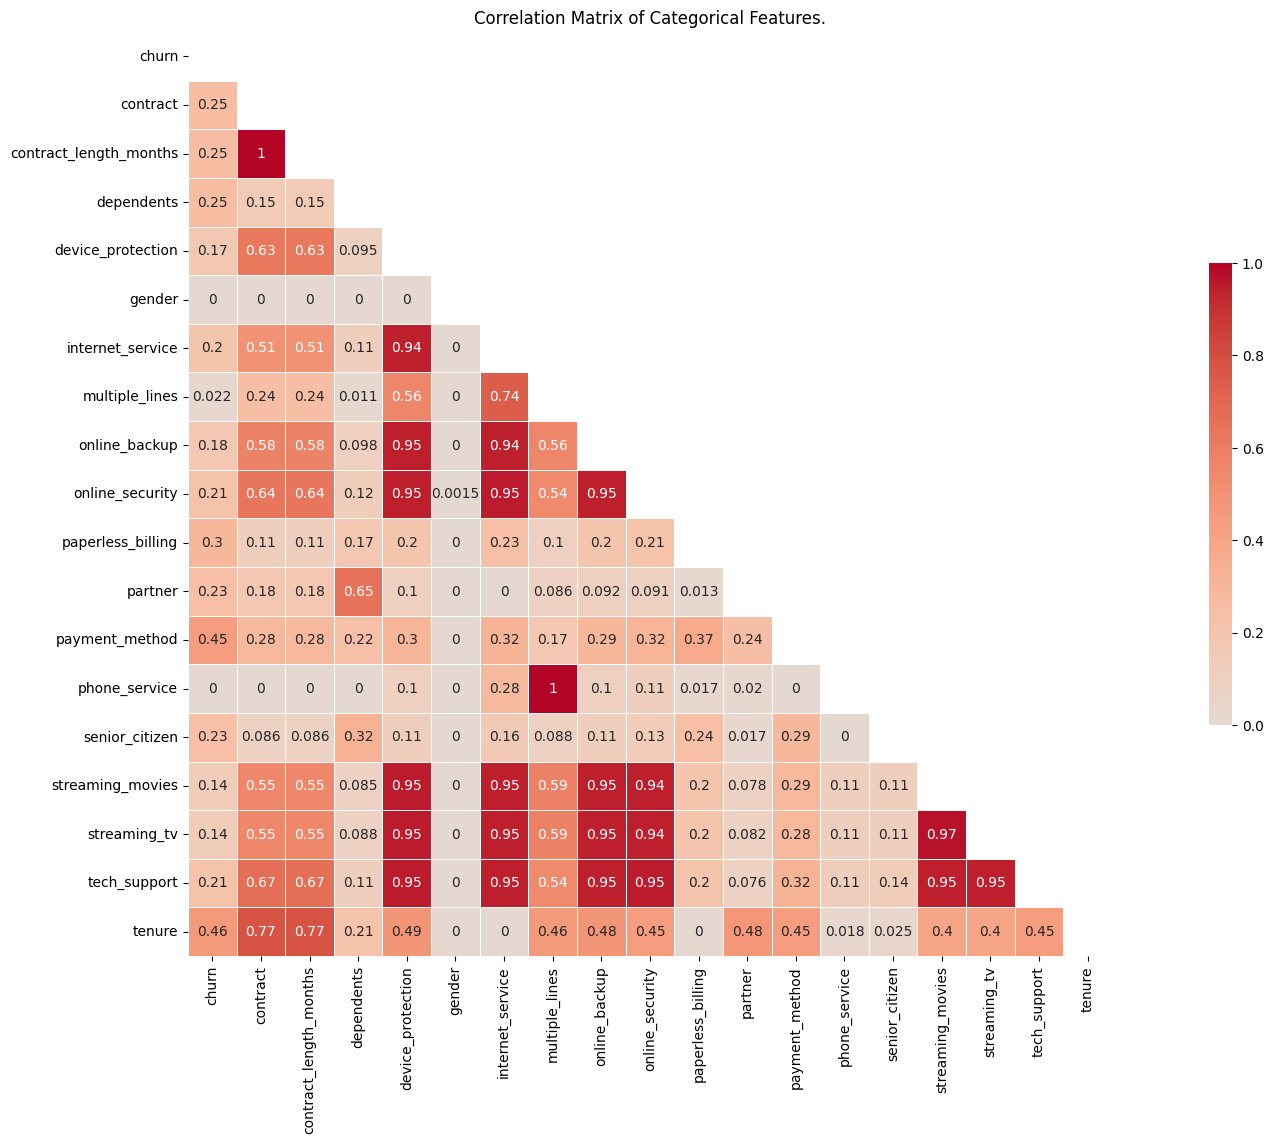

In [34]:
# Plotting the correlation matrix for categorical variables with a heatmap.

# A triangular mask is created to hide the upper triangle of the heatmap. This is done to avoid redundancy since correlation matrices are symmetrical.
mask = np.triu(np.ones_like(corr_matrix.round(2), dtype=float))
f, ax = plt.subplots(figsize=(25, 12))

sns.heatmap(
    corr_matrix, #.round(1), 
    center= -0.07, 
    cmap="coolwarm", 
    square=True,
    linewidth=0.5, 
    cbar_kws={"shrink": .5}, 
    annot=True, 
    mask=mask
)
ax.set_title('Correlation Matrix of Categorical Features.');

There is high collinearity among service-related features. For modeling purposes, as most of the features of the services category provide similar information, we may consider reducing features in this category, while  preserving or even enhancing predictive powers. This will reduce the collinearity of our predictors.

Contract_length_months and contracts are also highly correlated. Since both features are ordinal categorical, we can use statistical tests and visualizations to explore their association with the target variable.

We will perform a chi-squared test to assess the independence between each of the ordinal categorical features and the target variable. 

In [35]:
# Creating a contingency table for contract feature and the target variable
contingency_table = pd.crosstab(df1['contract'], df1['churn'])

# Performing the chi-squared test
chi2, p, _, _ = chi2_contingency(contingency_table)

p_contract = p

print(f"P-value for 'contract': {p}")

P-value for 'contract': 5.863038300673391e-258


In [36]:
# Creating a contingency table for contract_length_months feature and the target variable
contingency_table = pd.crosstab(df1['contract_length_months'], df1['churn'])

# Performing the chi-squared test
chi2, p1, _, _ = chi2_contingency(contingency_table)
p_contract_length_month = p1

print(f"P-value for 'contract_length_months': {p1}")

P-value for 'contract_length_months': 5.863038300673391e-258


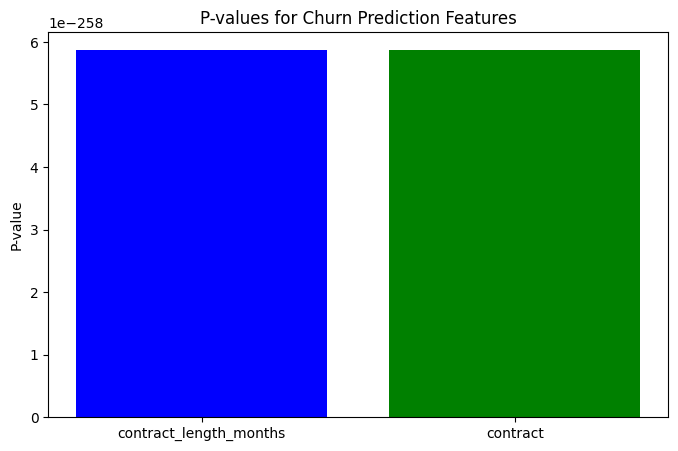

In [37]:
# import matplotlib.pyplot as plt

# Vizualising the p-values of both the tests
p_values = [p_contract_length_month, p_contract]

features = ['contract_length_months', 'contract']

# Bar plot for p-values
plt.figure(figsize=(8, 5))
plt.bar(features, p_values, color=['blue', 'green'])
plt.title('P-values for Churn Prediction Features')
plt.ylabel('P-value')
plt.show()

Both the features have p values less than 0.05, however, they have similar levels of p-values. Based on our initial impact analysis of the features in our models, contract feature showed more predictive powers for churn class(resulting in higher recall). We will retain this feature and drop contract_length_months feature.

We will now drop highly correlated features including services features and contract length feature and create an new correlation matrix

In [38]:
columns_to_exclude = ['partner',  'streaming_movies', 'tech_support', 'phone_service', 'contract_length_months',
       'paperless_billing','online_security', 'online_backup', 'streaming_tv', 'device_protection'] 

# Exclude the specified columns
df1 = df1.drop(columns=columns_to_exclude)

In [39]:
# Creating a correlation matrix after removing the highly correlated features.
# Putting together quantitative features into the variable 'interval_cols'.
interval_cols = ['monthly_charges', 'total_charges', 'monthly_to_total_ratio', 'tenure_monthly_charges_interaction' ]

# Using the phik_matrix function from the phik library to calculate the Phi-K correlation matrix.
# This matrix measures the correlation between categorical and numerical variables.

df1_cat = df1[df1.columns.difference(interval_cols)]
corr_matrix = df1_cat.phik_matrix(njobs=1)
# corr_matrix 
corr_matrix.round(2)

interval columns not set, guessing: ['churn']


churn  contract  dependents  gender  internet_service  \
churn              1.00      0.25        0.25     0.0              0.20   
contract           0.25      1.00        0.15     0.0              0.51   
dependents         0.25      0.15        1.00     0.0              0.11   
gender             0.00      0.00        0.00     1.0              0.00   
internet_service   0.20      0.51        0.11     0.0              1.00   
multiple_lines     0.02      0.24        0.01     0.0              0.74   
payment_method     0.45      0.28        0.22     0.0              0.32   
senior_citizen     0.23      0.09        0.32     0.0              0.16   
tenure             0.46      0.77        0.21     0.0              0.00   

                  multiple_lines  payment_method  senior_citizen  tenure  
churn                       0.02            0.45            0.23    0.46  
contract                    0.24            0.28            0.09    0.77  
dependents                  0.01            0.22            0.32    0.21  
gender                      0.00            0.00            0.00    0.00  
internet_service            0.74            0.32            0.16    0.00  
multiple_lines              1.00            0.17            0.09    0.46  
payment_method              0.17            1.00            0.29    0.45  
senior_citizen              0.09            0.29            1.00    0.03  
tenure                      0.46            0.45            0.03    1.00

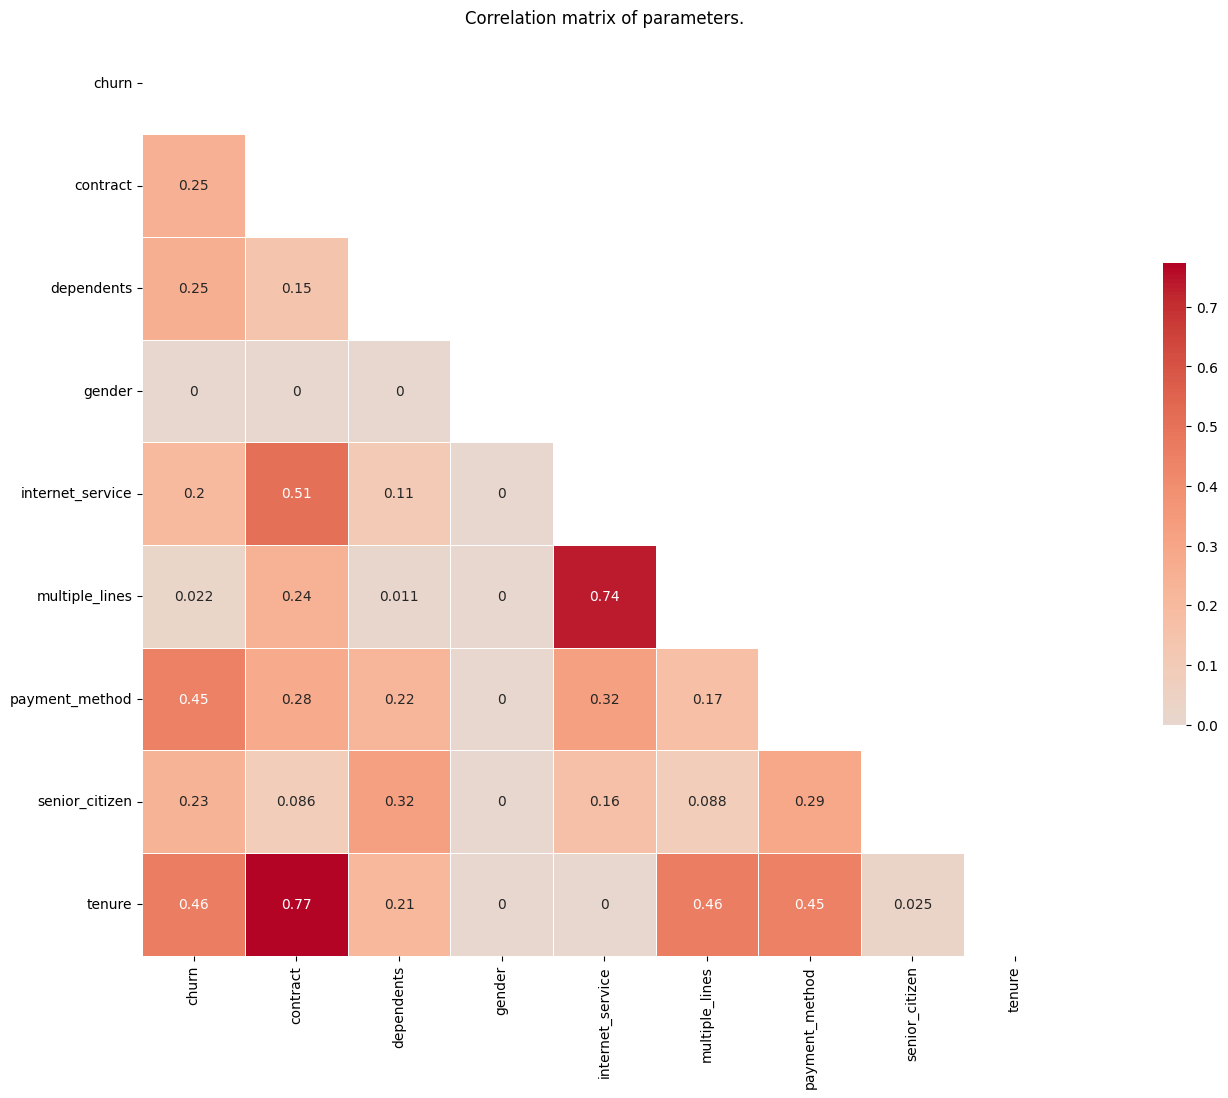

In [40]:
# Displaying the correlation matrix using a heatmap after removing highly correlated features.
mask = np.triu(np.ones_like(corr_matrix.round(2), dtype=float))
f, ax = plt.subplots(figsize=(25, 12))

sns.heatmap(
    corr_matrix, #.round(1), 
    center= -0.07, 
    cmap="coolwarm", 
    square=True,
    linewidth=0.5, 
    cbar_kws={"shrink": .5}, 
    annot=True, 
    mask=mask
)
ax.set_title('Correlation matrix of parameters.');

Collinearity in categorical variables has significantly reduced now.

We will further analyze collinearity of categorical variables pair wise by Cramér's V Matrix as follows:-

In [41]:
def cramers_v(df):
    """
    The function will return a matrix with Cramér's V values for each pair of variables.
    """
    columns = df.select_dtypes(include='object').columns
    cramers_matrix = pd.DataFrame(index=columns, columns=columns, dtype=float)

    for col1 in columns:
        for col2 in columns:
            if col1 == col2:
                continue

            contingency_table = pd.crosstab(df[col1], df[col2])
            chi2, _, _, _ = chi2_contingency(contingency_table)
            n = contingency_table.sum().sum()
            cramers_value = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))
            cramers_matrix.at[col1, col2] = cramers_value

    return cramers_matrix


# Calculating Cramér's V for all pairs of categorical variables
cramers_matrix = cramers_v(df1)

print("Cramér's V Matrix:")
print(cramers_matrix)

Cramér's V Matrix:
                                      gender  senior_citizen  dependents  \
gender                                   NaN        0.001488    0.010207   
senior_citizen                      0.001488             NaN    0.210765   
dependents                          0.010207        0.210765         NaN   
tenure                              0.098559        0.103183    0.201235   
multiple_lines                      0.009452        0.146643    0.025094   
internet_service                    0.011320        0.265324    0.180267   
contract                            0.008153        0.143868    0.244212   
payment_method                      0.018646        0.195985    0.150744   
tenure_monthly_charges_interaction  0.543666        0.595689    0.577710   

                                      tenure  multiple_lines  \
gender                              0.098559        0.009452   
senior_citizen                      0.103183        0.146643   
dependents                  

From cramers matrix, we can see that there are no materially correlated feature fairs within categorical variables. 

We will now check correlation of numeric features though variance inflation factor(VIF) and Pearson correlation matrix

In [42]:
# List of numeric columns
columns_to_keep = ['monthly_charges', 'total_charges', 'monthly_to_total_ratio', 'tenure_monthly_charges_interaction' ]

# Creating a new DataFrame with only the specified columns
df_vif = df1[columns_to_keep].copy()

# Defining a function return VIF data
def calculate_vif(data_frame):
    # Scale the features
    scaler = StandardScaler()
    data_frame_scaled = pd.DataFrame(scaler.fit_transform(data_frame), columns=data_frame.columns)
    
    # Calculate VIF
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data_frame_scaled.columns
    vif_data["VIF"] = [variance_inflation_factor(data_frame_scaled.values, i) for i in range(data_frame_scaled.shape[1])]

    return vif_data

# Calculating VIF for each variable
vif_results = calculate_vif(df_vif)

# Sorting the VIF results in descending order
vif_results = vif_results.sort_values(by='VIF', ascending=False)

print(vif_results)

                             Variable         VIF
3  tenure_monthly_charges_interaction  673.554807
1                       total_charges  671.437102
0                     monthly_charges    1.799025
2              monthly_to_total_ratio    1.307232


tenure_monthly_charges_interaction and total_charges features have high vif scores. It indicates a high degree of multicollinearity among these features. 

We will also create a Pearson correlation matrix to visualize the collinearity.

Multicollinearity can lead to unstable coefficient estimates, making it challenging to interpret the contribution of individual features to the model.

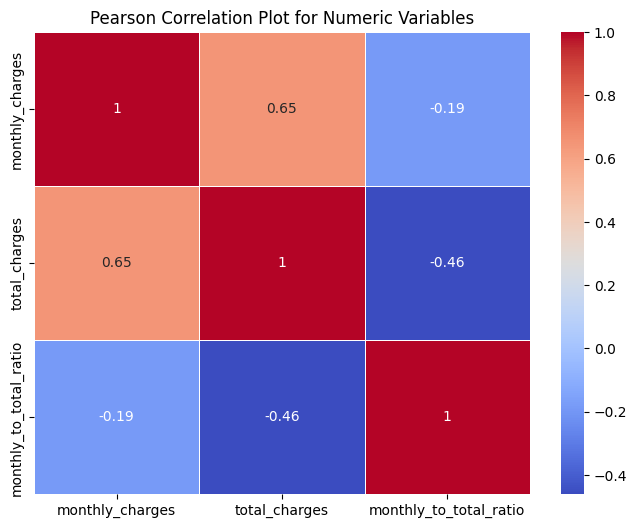

In [43]:
# Calculating the Pearson correlation matrix
correlation_matrix = df_vif.corr()

# Creating a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Pearson Correlation Plot for Numeric Variables')
plt.show()

Multicollinearity can lead to unstable coefficient estimates, making it challenging to interpret the contribution of individual features to the model.
We will drop the tenure_monthly_charges_interaction feature which has a higher vif score compared to the total_charges feature and check vif score again.

In [44]:
df1.drop('tenure_monthly_charges_interaction', inplace=True, axis = 1)

In [45]:
# VIF and Pearson correlation matrix after removing highly correlated numeric features.

# List of numeric columns
columns_to_keep = ['monthly_charges', 'total_charges', 'monthly_to_total_ratio']

# Creating a new DataFrame with only the specified columns
df_vif = df1[columns_to_keep].copy()

# Defining a function return VIF data
def calculate_vif(data_frame):
    # Scale the features
    scaler = StandardScaler()
    data_frame_scaled = pd.DataFrame(scaler.fit_transform(data_frame), columns=data_frame.columns)
    
    # Calculate VIF
    vif_data = pd.DataFrame()
    vif_data["Variable"] = data_frame_scaled.columns
    vif_data["VIF"] = [variance_inflation_factor(data_frame_scaled.values, i) for i in range(data_frame_scaled.shape[1])]

    return vif_data

# Calculating VIF for each variable
vif_results = calculate_vif(df_vif)

# Sorting the VIF results in descending order
vif_results = vif_results.sort_values(by='VIF', ascending=False)

print(vif_results)

                 Variable       VIF
1           total_charges  2.187964
0         monthly_charges  1.785527
2  monthly_to_total_ratio  1.306556


A vif score less than 5 looks reasobale. So we will keep both these numeric variables.

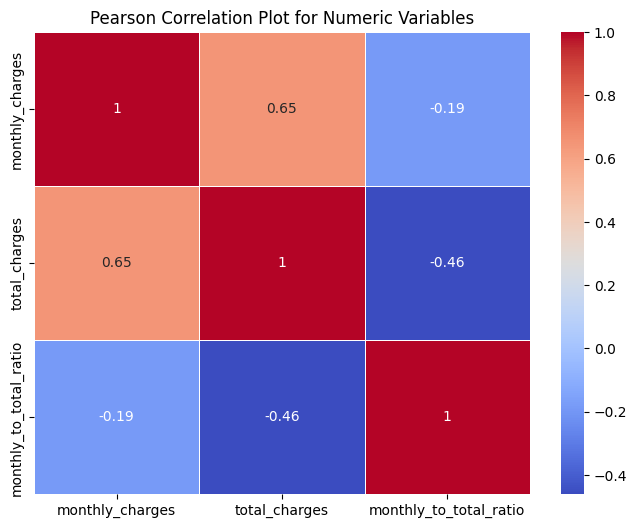

In [46]:
# Calculating the Pearson correlation matrix
correlation_matrix = df_vif.corr()

# Creating a heatmap using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Pearson Correlation Plot for Numeric Variables')
plt.show()

Multicollinearity in numeric variables has now been removed

In [47]:
# Remaining features from the original data set. However, we will engineer a few new features in the sections ahead and 
# assess their impact on our models.
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   gender                  7043 non-null   object 
 1   senior_citizen          7043 non-null   object 
 2   dependents              7043 non-null   object 
 3   tenure                  7043 non-null   object 
 4   multiple_lines          7043 non-null   object 
 5   internet_service        7043 non-null   object 
 6   contract                7043 non-null   object 
 7   payment_method          7043 non-null   object 
 8   monthly_charges         7043 non-null   float64
 9   total_charges           7043 non-null   float64
 10  churn                   7043 non-null   int64  
 11  monthly_to_total_ratio  7043 non-null   float64
dtypes: float64(3), int64(1), object(8)
memory usage: 660.4+ KB


## Preprocessing

###### After the EDA, we will now encapsulate all of our preprocessing steps in a class and use it for training, validation, and testing data separately to prevent any information leakage

In [48]:
class OrdinalEncoderWithNames(BaseEstimator, TransformerMixin):
    """ 
    OrdinalEncoderWithNames is a custom transformer that wraps the OrdinalEncoder and 
    implements the get_feature_names_out() method by returning the input features
    
    """
    
    def __init__(self):
        self.encoder = OrdinalEncoder()

    def fit(self, X, y=None):
        self.encoder.fit(X, y)
        return self

    def transform(self, X, y=None):
        return self.encoder.transform(X)

    def get_feature_names_out(self, input_features=None):
        return input_features

class DataPreprocessor:
    def __init__(self, df):
        self.df = df

    def pre_process(self):
        df = self.df.copy()
        df = df.drop('customerID', axis=1)

         # Convert TotalCharges to float data type
        df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
        df.TotalCharges = df.TotalCharges.astype(float)
        df['TotalCharges'].fillna(df['TotalCharges'].median(), inplace=True)

        #Tenure is an ordinal categorical feature. We should convert it accordingly.
        df['tenure'] = df['tenure'].astype('object')

        #Senior citizen is a nominal categorical variable, and we will convert it accordingly
        df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')

        def clean_column_name(col):
            # Use regular expression to insert underscore before capital letters (except at the beginning)
            cleaned_col = re.sub(r'([a-z0-9])([A-Z])', r'\1_\2', col)
            # Convert to lowercase
            return cleaned_col.lower()

        df.columns = [clean_column_name(col) for col in df.columns]

        df.churn = df.churn.apply(lambda x: 1 if x == 'Yes' else 0)

        # # Feature Engineering

        # Contract Length in Months
        contract_mapping = {'Month-to-month': 1, 'One year': 12, 'Two year': 24}
        df['contract_length_months'] = df['contract'].map(contract_mapping).astype(object)

        # Monthly Charges to Total Charges Ratio
        df['monthly_to_total_ratio'] = df['monthly_charges'] / df['total_charges'].astype(int)

        # Interaction Features between tenure and monthly charges
        df['tenure_monthly_charges_interaction'] = df['tenure'] * df['monthly_charges'].astype(int)

        columns_to_exclude = ['partner', 'tech_support', 'streaming_movies', 'phone_service',
                              'paperless_billing','online_security', 'online_backup', 'streaming_tv', 
                              'device_protection', 'contract_length_months', 'tenure_monthly_charges_interaction'] 

        # Exclude the specified columns
        df = df.drop(columns=columns_to_exclude)

        # Splitting target and predictor variables
        X = df.drop('churn', axis=1)
        y = df['churn']

        # Segregating categorical, ordinal, and numeric columns for ease of encoding
        categorical_cols = ['gender', 'senior_citizen', 'dependents', 'multiple_lines',	'internet_service' , 
                             'payment_method']
        ordinal_cols = ['contract', 'tenure']
        numeric_cols = ['monthly_charges', 'total_charges', 'monthly_to_total_ratio']#, 'tenure_monthly_charges_interaction']


        # Create transformers for each feature type
        categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

        ordinal_transformer = Pipeline(steps=[('ordinal', OrdinalEncoderWithNames())])

        numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])

        # Use ColumnTransformer to apply different transformations to different feature types
        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', categorical_transformer, categorical_cols),
                ('ord', ordinal_transformer, ordinal_cols),
                ('num', numeric_transformer, numeric_cols)
            ])

        X.columns = [col.replace(' ', '_') for col in X.columns]

        X = preprocessor.fit_transform(X)

        X = pd.DataFrame(X, columns=preprocessor.get_feature_names_out())

        shortened_names = {
            # 'cat__paperless_billing_No': 'not_paperless',
            # 'cat__paperless_billing_Yes': 'paperless',
            'cat__gender_Female': 'female',
            'cat__gender_Male': 'male',
            'cat__senior_citizen_0': 'not_senior',
            'cat__senior_citizen_1': 'senior',
            # 'cat__partner_No': 'no_partner',
            # 'cat__partner_Yes': 'partner',
            'cat__dependents_No': 'no_dependents',
            'cat__dependents_Yes': 'dependents',
            # 'cat__online_security_No': 'no_security',
            # 'cat__online_security_No internet service': 'no_internet_security',
            # 'cat__online_security_Yes': 'security',
            # 'cat__online_backup_No': 'no_backup',
            # 'cat__online_backup_No internet service': 'no_internet_backup',
            # 'cat__online_backup_Yes': 'backup',
            # 'cat__device_protection_No': 'no_protection',
            # 'cat__device_protection_No internet service': 'no_internet_protection',
            # 'cat__device_protection_Yes': 'protection',
            # 'cat__tech_support_No': 'no_tech_support',
            # 'cat__tech_support_No internet service': 'no_internet_tech_support',
            # 'cat__tech_support_Yes': 'tech_support',
            # 'cat__streaming_tv_No': 'no_streaming_tv',
            # 'cat__streaming_tv_No internet service': 'no_internet_streaming_tv',
            # 'cat__streaming_tv_Yes': 'streaming_tv',
            # 'cat__streaming_movies_No': 'no_streaming_movies',
            # 'cat__streaming_movies_No internet service': 'no_internet_streaming_movies',
            # 'cat__streaming_movies_Yes': 'streaming_movies',
            # 'cat__phone_service_No': 'no_phone',
            # 'cat__phone_service_Yes': 'phone',
            'cat__payment_method_Bank transfer (automatic)': 'bank_transfer_auto',
            'cat__payment_method_Credit card (automatic)': 'credit_card_auto',
            'cat__payment_method_Electronic check': 'e_check',
            'cat__payment_method_Mailed check': 'mailed_check',
            'cat__internet_service_DSL': 'dsl',
            'cat__internet_service_Fiber optic': 'fiber_optic',
            'cat__internet_service_No': 'no_internet',
            'cat__multiple_lines_No': 'no_multiple_lines',
            'cat__multiple_lines_No phone service': 'no_phone_service',
            'cat__multiple_lines_Yes': 'multiple_lines',
            'ord__contract': 'contract',
            # 'ord__contract_length_months': 'contract_months',
            'num__monthly_charges': 'monthly_charges',
            'num__total_charges': 'total_charges',
            'num__tenure': 'tenure',
            'num__monthly_to_total_ratio': 'monthly_to_total_ratio'
        #     'num__tenure_monthly_charges_interaction': 'tenure_monthly_charges_interaction',
         }

        X.columns = [shortened_names[col] if col in shortened_names else col for col in X.columns]

        X_array = X.values
        y_array = y.values


        return X, y, X_array, y_array

In [49]:
# Creating an object of the preprocessing class with our original df that was not used for preprocessing and EDA
df_preprocessed= DataPreprocessor(df)

In [50]:
# Using the pre-process method of the class to extract necessary data frames and  arrays for use in our modeling in the following sections
X, y, X_array, y_array = df_preprocessed.pre_process()

In [51]:
# Checking all the preprocessed variables are populating well
X.sample(2)

female  male  not_senior  senior  no_dependents  dependents  \
4306     0.0   1.0         1.0     0.0            0.0         1.0   
1805     0.0   1.0         1.0     0.0            0.0         1.0   

      no_multiple_lines  no_phone_service  multiple_lines  dsl  fiber_optic  \
4306                0.0               0.0             1.0  0.0          1.0   
1805                0.0               0.0             1.0  1.0          0.0   

      no_internet  bank_transfer_auto  credit_card_auto  e_check  \
4306          0.0                 0.0               1.0      0.0   
1805          0.0                 0.0               1.0      0.0   

      mailed_check  contract  ord__tenure  monthly_charges  total_charges  \
4306           0.0       0.0         40.0         0.913930       0.513536   
1805           0.0       2.0         72.0         0.459701       0.542488   

      monthly_to_total_ratio  
4306                0.011599  
1805                0.001013

In [52]:
y.sample(2)

5172    0
3463    0
Name: churn, dtype: int64

In [53]:
X_array

array([[1.        , 0.        , 1.        , ..., 0.11542289, 0.0012751 ,
        0.98005617],
       [0.        , 1.        , 1.        , ..., 0.38507463, 0.21586661,
        0.01691208],
       [0.        , 1.        , 1.        , ..., 0.35422886, 0.01031041,
        0.4684877 ],
       ...,
       [1.        , 0.        , 1.        , ..., 0.11293532, 0.03780868,
        0.07031588],
       [0.        , 1.        , 0.        , ..., 0.55870647, 0.03321025,
        0.22222323],
       [0.        , 1.        , 1.        , ..., 0.86965174, 0.78764136,
        0.00273105]])

In [54]:
y_array

array([0, 0, 1, ..., 0, 1, 0], dtype=int64)

###### To address the imbalance in our dataset, we will now create a class encapsulating resampling methods

In [55]:
class resampling:
    """ Class for handling various resampling techniques."""
    
    def __init__(self, X_array, y_array):
        """ Initialize the Resampling instance."""    
        
        self.X_array = X_array
        self.y_array = y_array

    def over_sampling(self):
        """ SMOTE oversampling that returns resampled features."""
        smote = SMOTE(random_state=42)  
        X_resampled, y_resampled = smote.fit_resample(self.X_array, self.y_array)
        return X_resampled, y_resampled

    def under_sampling(self):
        """ Random undersampling."""
        sampler = RandomUnderSampler(random_state=42)  
        X_resampled, y_resampled = sampler.fit_resample(self.X_array, self.y_array)
        return X_resampled, y_resampled
        
    def combined_sampling(self):
        """ Apply SMOTETomek combined sampling. """
        sampler = SMOTETomek(random_state=42)  # ACCURACY = 0.88, F1=.89
        X_resampled, y_resampled = sampler.fit_resample(self.X_array, self.y_array)
        return X_resampled, y_resampled
        

In [56]:
# Creating an instance of resampling class
resampled_array = resampling(X_array, y_array)

#Using the combined_sampling method in the class to create resampled predictor and target variables(combined_resampling provesd best for our model)
X_resampled, y_resampled = resampled_array.combined_sampling()

###### Creating a class for plotting evaluation metrics

In [57]:
class eval_plots():
    def __init__(self, labels=["Class 0", "Class 1"]):
        self.labels = labels
        
    def plot_confusion_matrix(self, y_actual,y_predict):
        
        """ Function to plot confusion matrix """
        
        cm = confusion_matrix(y_actual,y_predict) # Creating a (2, 2) confusion matrix
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=self.labels, yticklabels=self.labels)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

        return cm
    
    def plot_auc_roc(self, y_actual,y_predict_prob):
        
        """ Calculate ROC curve and AUC for the validation set """
        
        fpr, tpr, _ = roc_curve(y_actual,y_predict_prob) # arrays for false positives, true positives, and thresholds
        auc_roc = auc(fpr, tpr)
    
        # Plot the ROC curve for validation set
        plt.figure(figsize=(8, 8))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(auc_roc))
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Model')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('AUC_Receiver Operating Characteristic (ROC) Curve - Validation Set')
        plt.legend(loc='lower right')
        plt.show()

        return auc_roc
    
    def plot_precision_recall(self, y_actual,y_predict_prob):
        
        """ Calculate the Precision-Recall curve and AUC """
        
        precision, recall, _ = precision_recall_curve(y_actual,y_predict_prob) # arrays for precision, recall, and thresholds
        pr_auc = average_precision_score(y_actual,y_predict_prob)
    
        # Plot Precision-Recall curve
        plt.figure(figsize=(8, 8))
        plt.plot(recall, precision, color='darkgreen', lw=2, label='Precision-Recall curve (area = {:.2f})'.format(pr_auc))
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='upper right')

        return pr_auc
    
    def plot_lift_chart(self, y_actual,y_predict_prob):
        """ Creating a lift chart """
        
        sorted_probs_model = np.argsort(y_predict_prob)[::-1] # sorted and reversed
        cumulative_response_model = np.cumsum(y_actual[sorted_probs_model]) / y_actual.sum() # y_actual reindexed for the array
        
        # Define a random model for comparison
        random_model = np.random.choice([0, 1], size=len(y_actual), replace=True)
        cumulative_response_random = np.cumsum(random_model) / random_model.sum()
        
        # Plot the Lift Chart
        plt.figure(figsize=(8, 8))
        plt.plot(np.arange(1, len(y_actual) + 1), cumulative_response_model, color='darkred', lw=2, label='Model')
        plt.plot(np.arange(1, len(y_actual) + 1), cumulative_response_random, color='navy', lw=2, linestyle='--', label='Random Model')
        plt.xlabel('Number of Instances')
        plt.ylabel('Cumulative Response')
        plt.title('Lift Chart')
        plt.legend(loc='center right')
        plt.show()

        return cumulative_response_model, cumulative_response_random

###### Creating a class to calculate and plot feature importance

In [58]:
class FeatureImportanceVisualizer:
    def __init__(self, model, X, feature_names):
        self.model = model
        self.X = X
        self.feature_names = feature_names

    def calculate_feature_importance(self):
        # Extract weights from the first layer
        weights = self.model.layers[0].get_weights()[0]

        # Calculate feature importance based on weights
        feature_importance = np.mean(np.abs(weights), axis=1)

        # Sort features based on importance
        sorted_indices = np.argsort(feature_importance)[::-1]
        sorted_importance = feature_importance[sorted_indices]
        sorted_feature_names = self.feature_names[sorted_indices]

        return sorted_importance, sorted_feature_names

    def plot_pareto_chart(self):
        sorted_importance, sorted_feature_names = self.calculate_feature_importance()

        # Calculate cumulative sum of importance
        cumulative_importance = np.cumsum(sorted_importance)

        # Calculate total importance
        total_importance = np.sum(sorted_importance)

        # Calculate percentage of total importance
        percentage_importance = cumulative_importance / total_importance * 100

        # Plot Pareto chart
        fig, ax1 = plt.subplots(figsize=(10, 6))

        ax1.bar(range(len(sorted_importance)), sorted_importance, color='b', alpha=0.7, label='Feature Importance')
        ax1.set_xlabel('Feature')
        ax1.set_ylabel('Feature Importance', color='b')
        ax1.tick_params('y', colors='b')

        ax2 = ax1.twinx()
        ax2.plot(range(len(sorted_importance)), percentage_importance, color='r', marker='o', label='Cumulative Percentage')
        ax2.set_ylabel('Cumulative Percentage', color='r')
        ax2.tick_params('y', colors='r')

        ax1.set_xticks(range(len(sorted_importance)))
        ax1.set_xticklabels(sorted_feature_names, rotation=45, ha='right')
        ax1.set_title('Pareto Chart of Feature Importance')

        plt.show()

    def plot_top_features(self, top_n=5):
        sorted_importance, sorted_feature_names = self.calculate_feature_importance()

        # Take only the top N features
        top_importance = sorted_importance[:top_n]
        top_feature_names = sorted_feature_names[:top_n]

        # Plot feature importance for the top N features
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(top_importance)), top_importance)
        plt.xticks(range(len(top_importance)), top_feature_names, rotation=45, ha='right')
        plt.xlabel('Feature')
        plt.ylabel('Feature Importance')
        plt.title(f'Top {top_n} Feature Importance')

        plt.show()


## Train/Test Split

In [59]:
# Split the data into training, validation, and testing sets
X_train, X_temp, y_train, y_temp = train_test_split(X_resampled, y_resampled, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

We have split the data into training and test sets. We have also created a separate validation data set which will be used to refine the model including hyperprameter tuning and addressing overfitting. The test data set will be retained only for the final testing. This data set will act as truly unseen data.

## Modelling

For customer churn prediction, several  neural network models can be effective for binary classification. We will experiment with four models in this project: Feed Forward Neural Network(FNN), Multi-Layer Perception(MLP), Deep Neural Network(DNN), and Long Short-Term Memory(LSTM). We will compare their performance using metrics like accuracy, precision, recall, and F1 score. Additionally, we will tune hyperparameters for each model to optimize their performance. We will create visualizations to display their performance metrics and compare their performance to choose the best models.

### Brief summary of the models:

##### Feed Forward Neural Network (FNN):

FNNs are versatile and can model complex non-linear relationships in data. They are effective for tasks where the input features have intricate dependencie They are s: Suitable for customer churn prediction when there are non-linear patterns and interactions between various customer feature
s.


##### Multi-Layer Perception (MLP)

Similar to FNNs, MLPs can capture non-linear relationships and are capable of learning hierarchical features. They perform well in tasks with large amounts of They are elity: Effective for customer churn prediction when dealing with intricate patterns and dependencies in customer beh
avior.

##### Deep Neural Network(DNN)

DNNs extend the capabilities of MLPs with additional hidden layers, allowing them to learn hierarchical representations of data. They excel in capturing intricate and abstract They are scalability: Suitable for customer churn prediction when the relationships between features are highly complex and mult
i-faceted.

##### Long Short-Term Memory(LSTM)

LSTMs are a type of recurrent neural network (RNN) designed to handle sequential data and capture temporal dependencies. They are useful for customer churn prediction when the historical sequence of customer interactions or behaviors is crucial for predicting future churn.


In customer churn prediction, the intricate and dynamic nature of customer behavior often requires models that can capture complex relationships and patterns. FNNs, MLPs, DNNs, and LSTMs are well-suited for this task, each offering unique advantages based on the characteristic of our  data and the nature of the problem.

#### FNN-Feed Forward Neural Network

In [60]:
# Function to create the model
def create_model(optimizer='adam', dropout_rate=0.5):
    model = Sequential()
    model.add(Dense(64, input_dim=X_array.shape[1], activation='relu')) 
    model.add(Dropout(dropout_rate)) 
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid')) 
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) 
    return model
"""
In the create_model function as above:

Input Layer (64 neurons with ReLU activation): 
having 64 neurons allows the network to capture a diverse range of patterns and features from the input data, enabling it to learn complex 
representations. ReLU activation introduces non-linearity, helping the network model complex relationships within the data.

Dropout Layer (with a dropout rate of 0.5):
Dropout helps prevent overfitting by randomly dropping a fraction of neurons during training. This encourages the network to learn more 
robust and generalizable features. Acts as a form of model ensemble during training, considering different subsets of neurons in each 
iteration, improving overall model robustness.

Hidden Layer (32 neurons with ReLU activation):
The hidden layer acts as an abstraction layer, extracting higher-level features from the representations learned in the input layer.
ReLU activation introduces non-linearity, allowing the model to capture complex relationships in the data.

Output Layer (1 neuron with a sigmoid activation function):
Since the task is binary classification (churn or no churn), a single neuron with a sigmoid activation function is appropriate. 
It outputs probabilities, facilitating the decision-making process. Sigmoid activation provides output in the range (0, 1), 
allowing easy interpretation of the probability of a customer churning.

The chosen architecture balances model capacity, non-linearity, regularization, and interpretability, making it suitable for 
capturing intricate patterns in customer churn prediction while mitigating overfitting. 

"""
# Define hyperparameters to tune
optimizers = ['adam', 'sgd', 'rmsprop']
dropout_rates = [0.3, 0.5, 0.7]

"""  
The model is trained with three different optimizers - Adam, SGD (Stochastic Gradient Descent), and RMSprop.
Different dropout rates (0.3, 0.5, 0.7) are tested to find the optimal configuration.
"""

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

"""
Stratified K-Fold Cross-Validation with K=5 is employed for robust evaluation. The model is trained and evaluated multiple times, each 
time using a different fold for validation.
"""

best_accuracy = 0
best_hyperparameters = {}

# Loop through hyperparameters
for optimizer in optimizers:
    for dropout_rate in dropout_rates:
        accuracy_list = []

        # Cross-validation loop
        for train_index, test_index in kf.split(X_train, y_train):  # test_index = cv test index
            X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

            model = create_model(optimizer=optimizer, dropout_rate=dropout_rate)
            model.fit(X_train_cv, y_train_cv, epochs=10, batch_size=32, verbose=0)

            y_pred_prob_cv = model.predict(X_test_cv)
            y_pred_cv = (y_pred_prob_cv > 0.5).astype(int)
            accuracy_cv = accuracy_score(y_test_cv, y_pred_cv)
            accuracy_list.append(accuracy_cv)

        # Calculate average accuracy over cross-validation folds
        average_accuracy = sum(accuracy_list) / len(accuracy_list)

        print(f'Hyperparameters: optimizer={optimizer}, dropout_rate={dropout_rate}')
        print(f'Average accuracy across folds: {average_accuracy * 100:.2f}%\n')

        # Update best hyperparameters if average accuracy improves
        if average_accuracy > best_accuracy:
            best_accuracy = average_accuracy
            best_hyperparameters = {'optimizer': optimizer, 'dropout_rate': dropout_rate}

            # Save the best model for later use
            model_fnn = create_model(optimizer=optimizer, dropout_rate=dropout_rate)
            model_fnn.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

print("Best hyperparameters:", best_hyperparameters)
print("Best average accuracy across folds:", best_accuracy * 100)

"""
Model Selection:
The model with the highest average accuracy across folds is selected. The best hyperparameters (optimizer and dropout rate) are 
determined based on cross-validation results.

"""

# Evaluate the best model on the validation set
y_prob_fnn = model_fnn.predict(X_valid).squeeze()
y_pred_fnn = (y_prob_fnn > 0.5).astype(int)
accuracy_fnn = accuracy_score(y_valid, y_pred_fnn)
print(f"Accuracy on the validation data: {accuracy_fnn}")
"""
Model Training and Evaluation:
The best FNN model is trained on the entire training set using the optimal hyperparameters.
The model is then evaluated on a validation set to assess its performance.
"""

37/37 [==============================] - 0s 630us/step
Hyperparameters: optimizer=adam, dropout_rate=0.3
Average accuracy across folds: 80.36%

37/37 [==============================] - 0s 626us/step
Hyperparameters: optimizer=adam, dropout_rate=0.5
Average accuracy across folds: 79.81%

37/37 [==============================] - 0s 1ms/step
Hyperparameters: optimizer=adam, dropout_rate=0.7
Average accuracy across folds: 78.96%

37/37 [==============================] - 0s 770us/step
Hyperparameters: optimizer=sgd, dropout_rate=0.3
Average accuracy across folds: 77.49%

37/37 [==============================] - 0s 812us/step
Hyperparameters: optimizer=sgd, dropout_rate=0.5
Average accuracy across folds: 75.79%

37/37 [==============================] - 0s 801us/step
Hyperparameters: optimizer=sgd, dropout_rate=0.7
Average accuracy across folds: 72.87%

37/37 [==============================] - 0s 582us/step
Hyperparameters: optimizer=rmsprop, dropout_rate=0.3
Average accuracy across folds: 79

'\nModel Training and Evaluation:\nThe best FNN model is trained on the entire training set using the optimal hyperparameters.\nThe model is then evaluated on a validation set to assess its performance.\n'

#### Performance metrics and plots for feed forward neural network with validation data

In [61]:
# Print additional metrics
print("Detailed Classification Report:")
print(classification_report(y_valid, y_pred_fnn))

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.71      0.77       980
           1       0.74      0.87      0.80       948

    accuracy                           0.79      1928
   macro avg       0.80      0.79      0.79      1928
weighted avg       0.80      0.79      0.79      1928



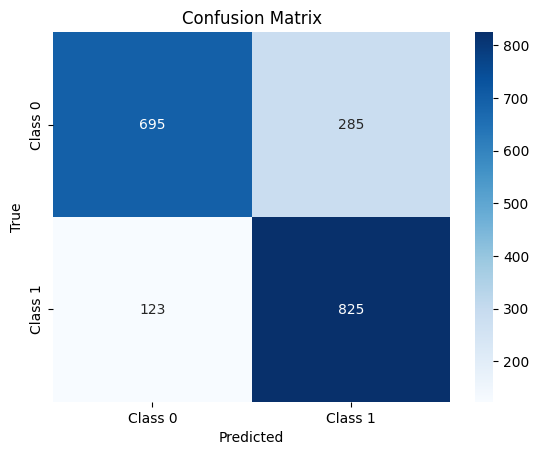

array([[695, 285],
       [123, 825]], dtype=int64)

In [62]:
fnn_cm_plot = eval_plots()
fnn_cm_plot.plot_confusion_matrix(y_valid, y_pred_fnn)

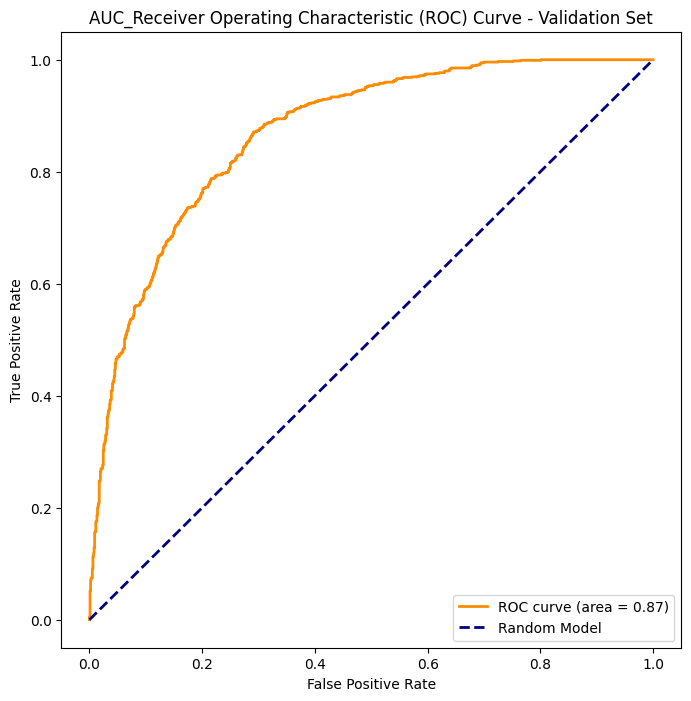

0.8693651511237407

In [63]:
fnn_roc_curve = eval_plots()
fnn_roc_curve .plot_auc_roc(y_valid, y_prob_fnn)

0.8513593638538306

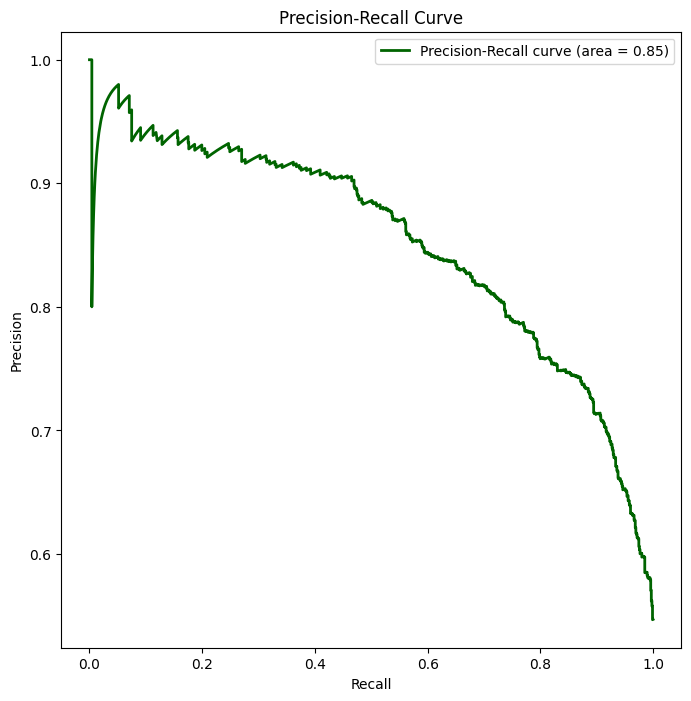

In [64]:
fnn_precision_recall_curve = eval_plots()
fnn_precision_recall_curve .plot_precision_recall(y_valid, y_prob_fnn)

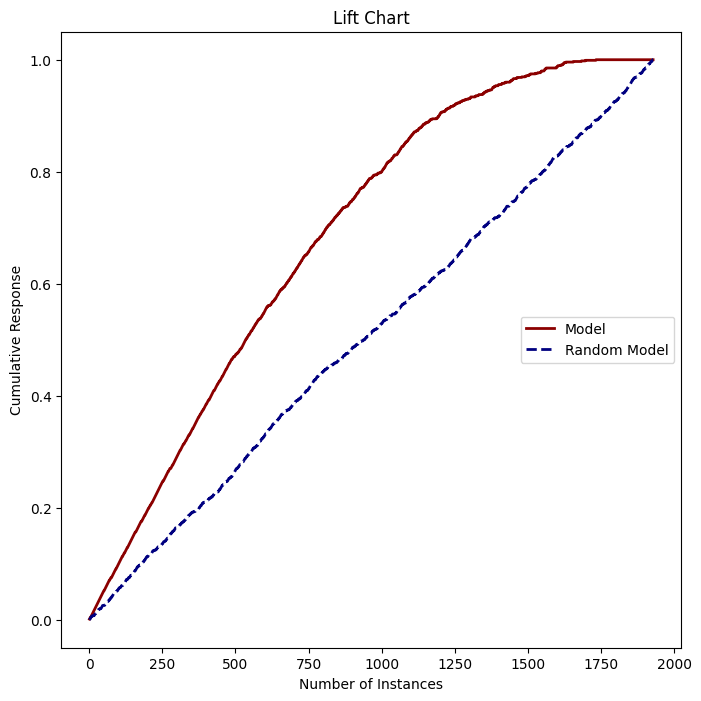

(array([0.00105485, 0.0021097 , 0.00316456, ..., 1.        , 1.        ,
        1.        ]),
 array([0.        , 0.00101833, 0.00101833, ..., 0.99898167, 1.        ,
        1.        ]))

In [65]:
fnn_lift_chart = eval_plots()
fnn_lift_chart.plot_lift_chart(y_valid, y_prob_fnn)

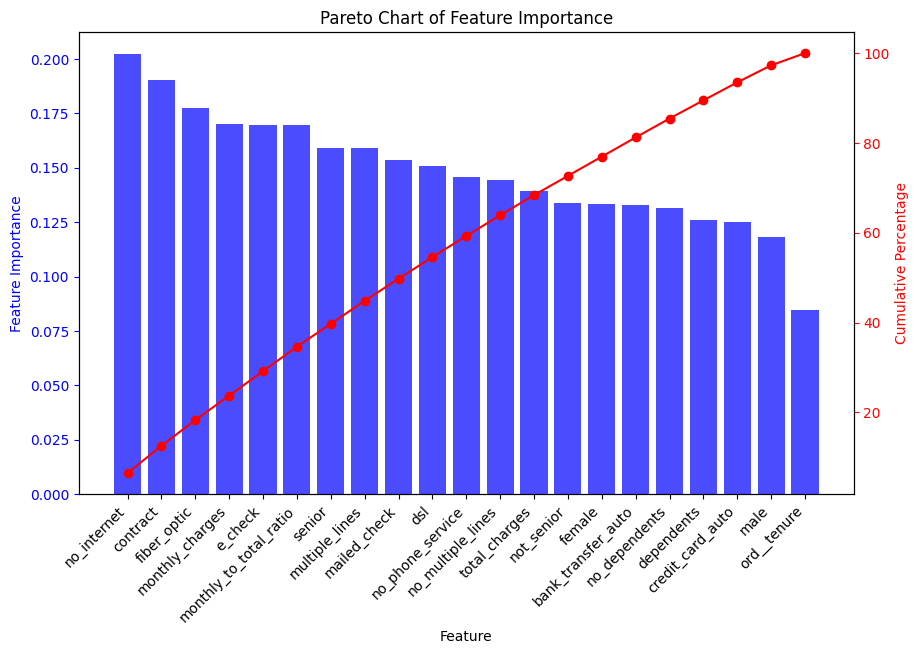

In [66]:
visualizer_fnn = FeatureImportanceVisualizer(model_fnn, X, X.columns)
visualizer_fnn.plot_pareto_chart()

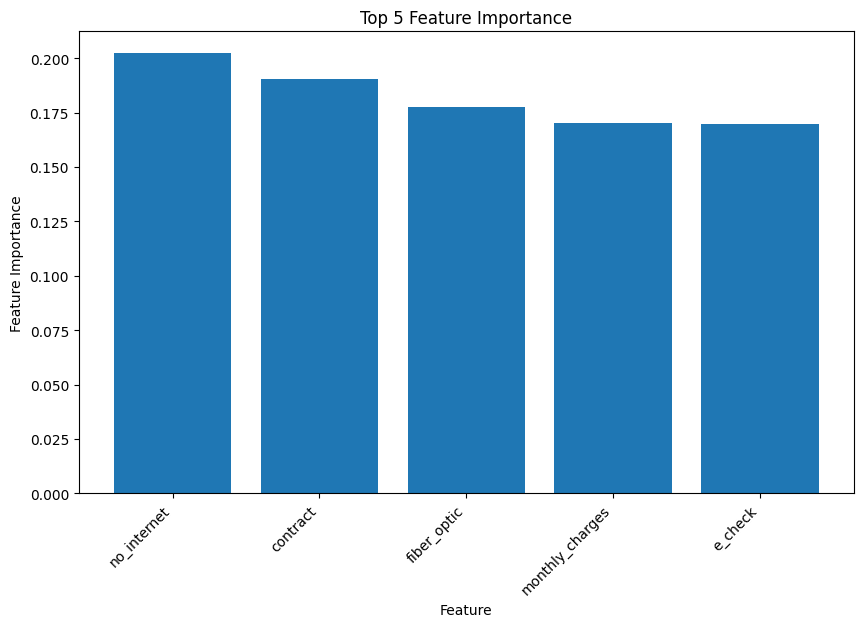

In [67]:
visualizer_fnn.plot_top_features(top_n=5)

Top 5 features for fnn model based on weights include no internet contract, fiber optic, monthly charges, and customers using electronic checks

Predicted Probabilities:
[0.9524865  0.19457297 0.9352019  ... 0.85419154 0.2595402  0.03829835]


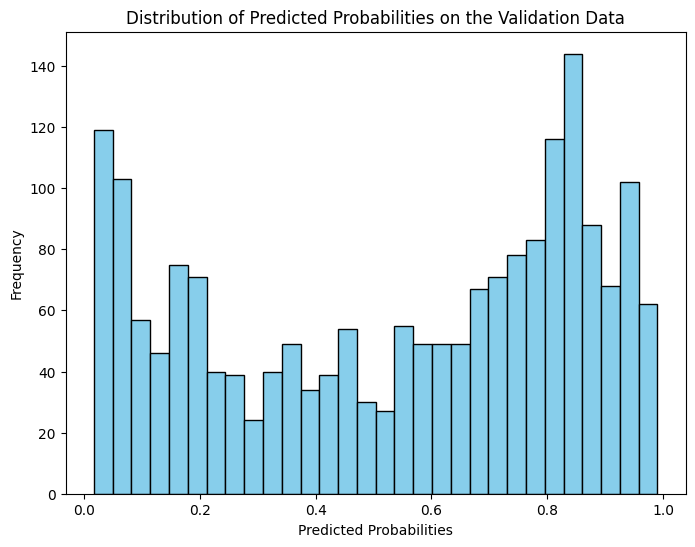

In [68]:
print("Predicted Probabilities:")
print(y_prob_fnn)

# Visualize the distribution of predicted probabilities
plt.figure(figsize=(8, 6))
plt.hist(y_prob_fnn, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Predicted Probabilities on the Validation Data')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.show()

#### Performance metrics and plots for feed forward neural network with test data

In [69]:
# Evaluate the best model on the test set
y_prob_fnn_test = model_fnn.predict(X_test).squeeze()
y_pred_fnn_test = (y_prob_fnn_test > 0.5).astype(int)
accuracy_fnn_test = accuracy_score(y_test, y_pred_fnn_test)
print(f"Accuracy on the test data: {accuracy_fnn_test}")

61/61 [==============================] - 0s 571us/step
Accuracy on the test data: 0.7883817427385892


In [70]:
# Print additional metrics
print("Detailed Classification Report:")
print(classification_report(y_test, y_pred_fnn_test))

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.70      0.77       981
           1       0.74      0.88      0.80       947

    accuracy                           0.79      1928
   macro avg       0.80      0.79      0.79      1928
weighted avg       0.80      0.79      0.79      1928



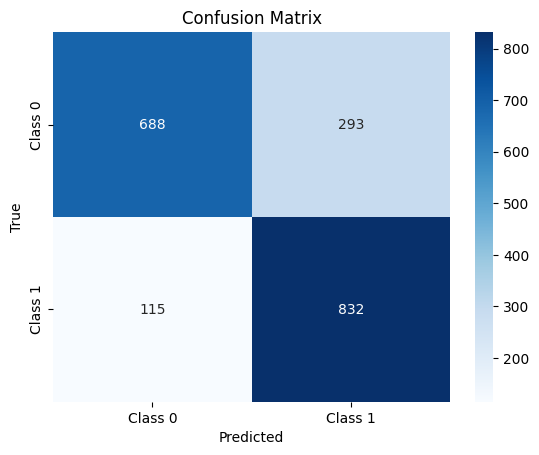

array([[688, 293],
       [115, 832]], dtype=int64)

In [71]:
fnn_cm_plot_test = eval_plots()
fnn_cm_plot_test.plot_confusion_matrix(y_test, y_pred_fnn_test)

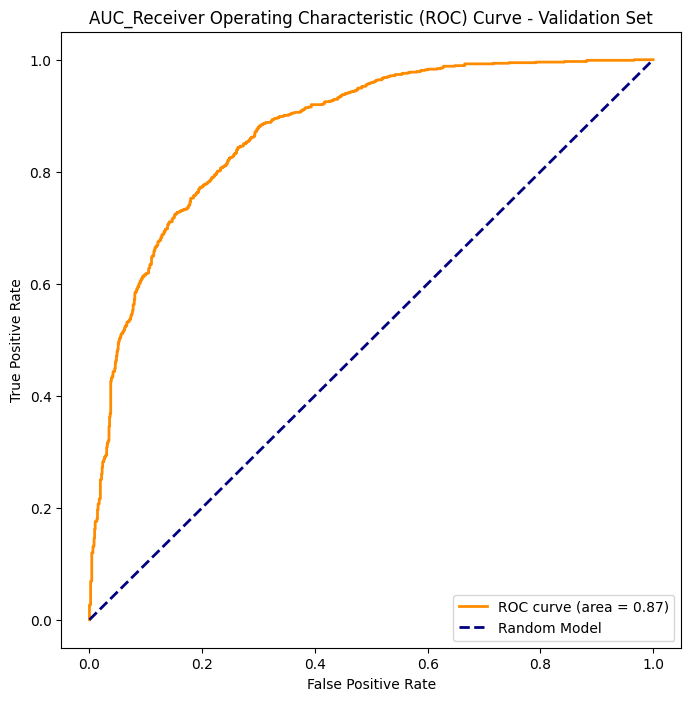

0.8736457314099895

In [72]:
fnn_roc_curve_test = eval_plots()
fnn_roc_curve_test.plot_auc_roc(y_test, y_prob_fnn_test)

0.8567440822731338

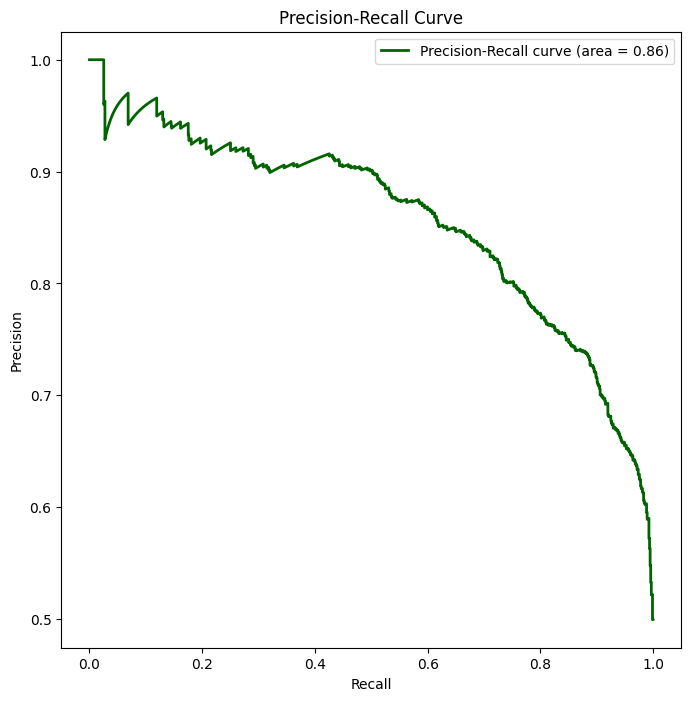

In [73]:
fnn_precision_recall_curve_test = eval_plots()
fnn_precision_recall_curve_test.plot_precision_recall(y_test, y_prob_fnn_test)

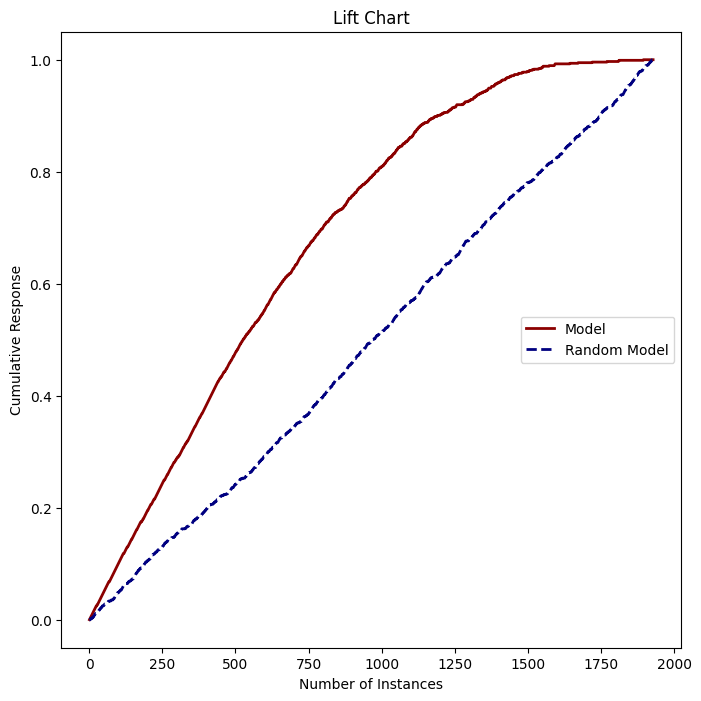

(array([0.00105597, 0.00211193, 0.0031679 , ..., 1.        , 1.        ,
        1.        ]),
 array([0.0010395, 0.0010395, 0.002079 , ..., 1.       , 1.       ,
        1.       ]))

In [74]:
fnn_lift_chart_test = eval_plots()
fnn_lift_chart_test.plot_lift_chart(y_test, y_prob_fnn_test)

Predicted Probabilities:
[0.8720927  0.59700763 0.8127576  ... 0.40569848 0.9662941  0.15719847]


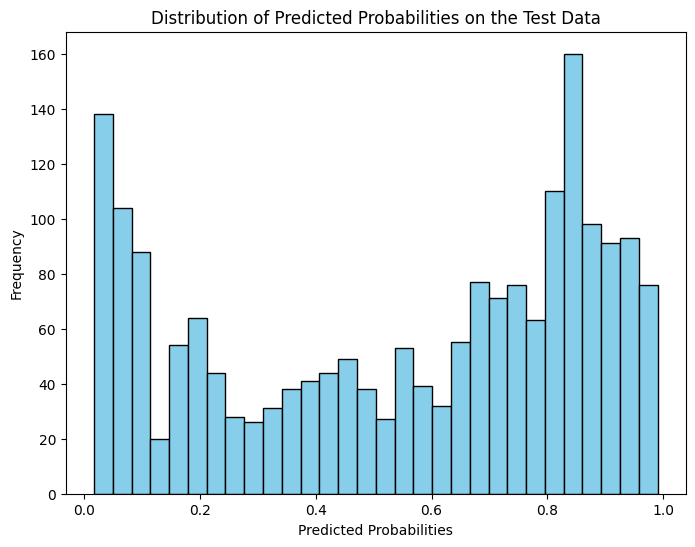

In [75]:
print("Predicted Probabilities:")
print(y_prob_fnn_test)

# Visualize the distribution of predicted probabilities
plt.figure(figsize=(8, 6))
plt.hist(y_prob_fnn_test, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Predicted Probabilities on the Test Data')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.show()

#### MLP (Multi-Layer Perception) 

In [76]:
# Function to create the model

def create_mlp_model(optimizer='adam', dropout_rate=0.5):
    """
    Creates an MLP model with specified hyperparameters.

    Parameters:
    - optimizer: Optimization algorithm for model training (default='adam').
    - dropout_rate: Fraction of input units to drop during training (default=0.5).

    Returns:
    - model: Compiled MLP model.
    """
    model = Sequential()
    model.add(Dense(256, input_dim=X_array.shape[1], activation='relu')) 
    model.add(Dropout(dropout_rate)) 
    model.add(Dense(128, activation='relu')) 
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid')) 
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy']) 
    return model
    
# Define hyperparameters to tune
optimizers = ['adam', 'sgd', 'rmsprop']
dropout_rates = [0.3, 0.5, 0.7]

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_accuracy = 0
best_hyperparameters = {}

# Loop through hyperparameters
for optimizer in optimizers:
    for dropout_rate in dropout_rates:
        accuracy_list = []

        # Cross-validation loop
        for train_index, test_index in kf.split(X_train, y_train):  # test_index = cv test index
            X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

            model = create_model(optimizer=optimizer, dropout_rate=dropout_rate)
            model.fit(X_train_cv, y_train_cv, epochs=10, batch_size=32, verbose=0)

            y_pred_prob_cv = model.predict(X_test_cv)
            y_pred_cv = (y_pred_prob_cv > 0.5).astype(int)
            accuracy_cv = accuracy_score(y_test_cv, y_pred_cv)
            accuracy_list.append(accuracy_cv)

        # Calculate average accuracy over cross-validation folds
        average_accuracy = sum(accuracy_list) / len(accuracy_list)

        print(f'Hyperparameters: optimizer={optimizer}, dropout_rate={dropout_rate}')
        print(f'Average accuracy across folds: {average_accuracy * 100:.2f}%\n')

        # Update best hyperparameters if average accuracy improves
        if average_accuracy > best_accuracy:
            best_accuracy = average_accuracy
            best_hyperparameters = {'optimizer': optimizer, 'dropout_rate': dropout_rate}

            # Save the best model for later use
            model_mlp = create_model(optimizer=optimizer, dropout_rate=dropout_rate)
            model_mlp.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

print("Best hyperparameters:", best_hyperparameters)
print("Best average accuracy across folds:", best_accuracy * 100)

# Evaluate the best model on the validation set
y_prob_mlp = model_mlp.predict(X_valid).squeeze()
y_pred_mlp = (y_prob_mlp > 0.5).astype(int)
accuracy_mlp = accuracy_score(y_valid, y_pred_mlp)
print(f"Accuracy on the validation data: {accuracy_mlp}")

37/37 [==============================] - 0s 1ms/step
Hyperparameters: optimizer=adam, dropout_rate=0.3
Average accuracy across folds: 79.82%

37/37 [==============================] - 0s 1ms/step
Hyperparameters: optimizer=adam, dropout_rate=0.5
Average accuracy across folds: 79.98%

37/37 [==============================] - 0s 1ms/step
Hyperparameters: optimizer=adam, dropout_rate=0.7
Average accuracy across folds: 79.05%

37/37 [==============================] - 0s 678us/step
Hyperparameters: optimizer=sgd, dropout_rate=0.3
Average accuracy across folds: 77.46%

37/37 [==============================] - 0s 1ms/step
Hyperparameters: optimizer=sgd, dropout_rate=0.5
Average accuracy across folds: 70.61%

37/37 [==============================] - 0s 772us/step
Hyperparameters: optimizer=sgd, dropout_rate=0.7
Average accuracy across folds: 73.32%

37/37 [==============================] - 0s 766us/step
Hyperparameters: optimizer=rmsprop, dropout_rate=0.3
Average accuracy across folds: 79.74%



#### Performance metrics and plots for MLP model with validation data

In [77]:
# Print additional metrics
print("Detailed Classification Report:")
print(classification_report(y_valid, y_pred_mlp))

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.75      0.78       980
           1       0.76      0.84      0.80       948

    accuracy                           0.79      1928
   macro avg       0.79      0.79      0.79      1928
weighted avg       0.79      0.79      0.79      1928



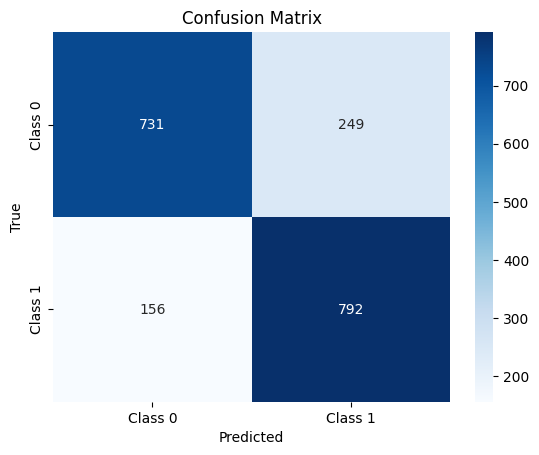

array([[731, 249],
       [156, 792]], dtype=int64)

In [78]:
mlp_cm_plot = eval_plots()
mlp_cm_plot.plot_confusion_matrix(y_valid, y_pred_mlp)

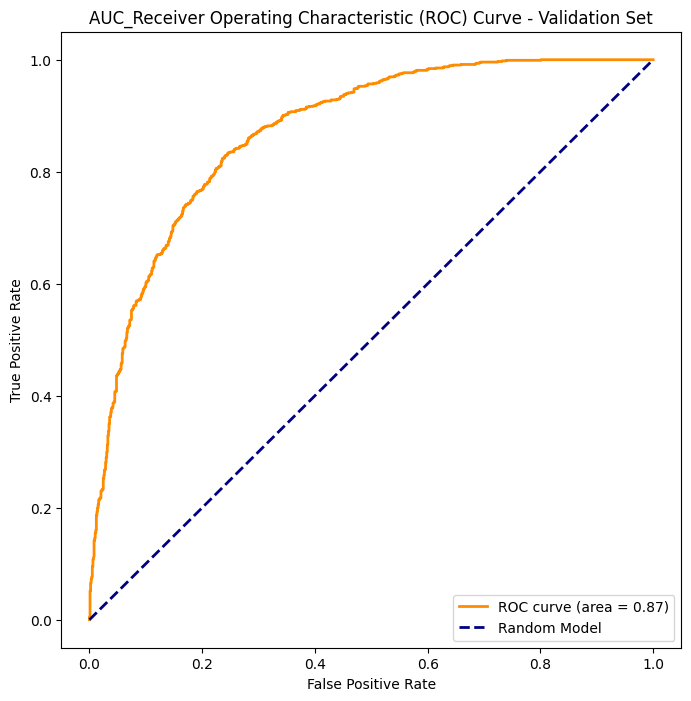

0.87101954705933

In [79]:
mlp_roc_curve = eval_plots()
mlp_roc_curve .plot_auc_roc(y_valid, y_prob_mlp)

0.8497173916418215

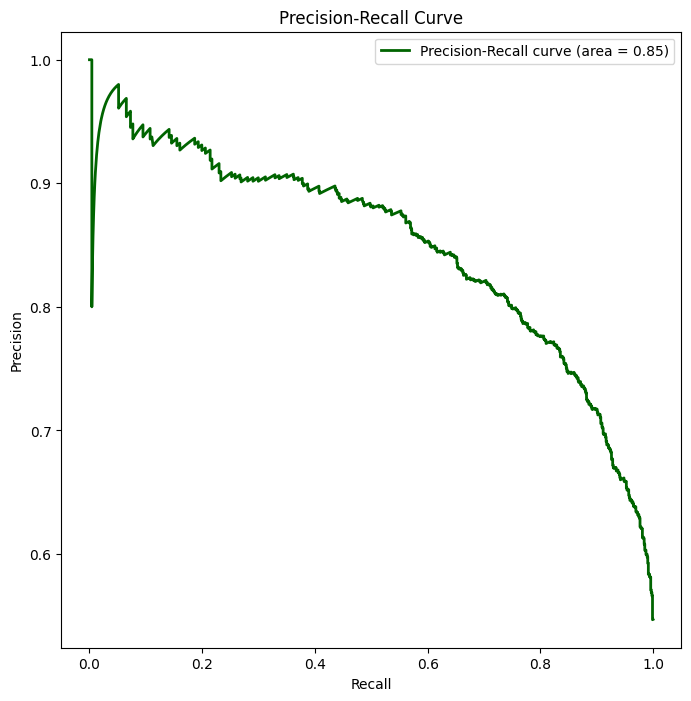

In [80]:
mlp_precision_recall_curve = eval_plots()
mlp_precision_recall_curve .plot_precision_recall(y_valid, y_prob_mlp)

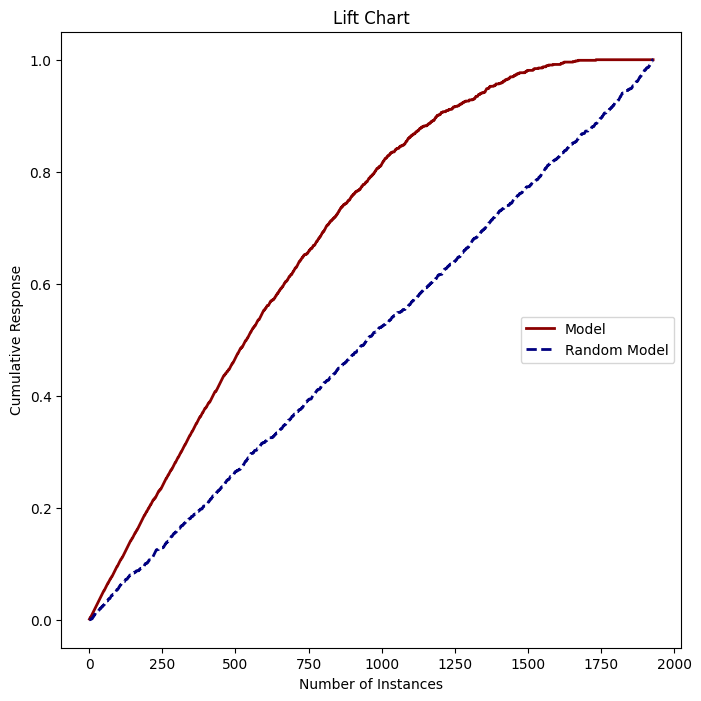

(array([0.00105485, 0.0021097 , 0.00316456, ..., 1.        , 1.        ,
        1.        ]),
 array([0.        , 0.        , 0.        , ..., 0.99892009, 1.        ,
        1.        ]))

In [81]:
mlp_lift_chart = eval_plots()
mlp_lift_chart.plot_lift_chart(y_valid, y_prob_mlp)

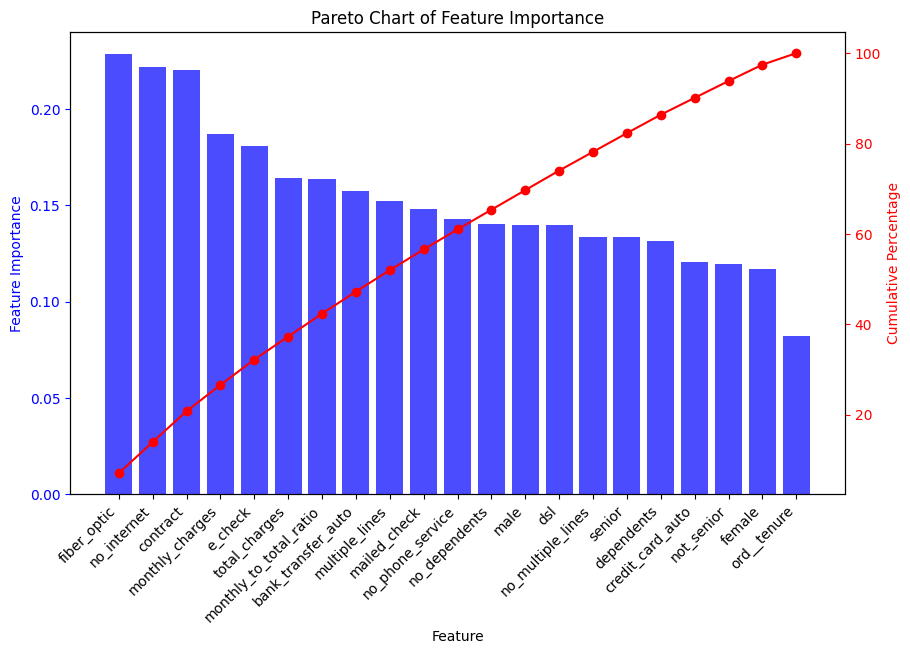

In [82]:
visualizer_mlp = FeatureImportanceVisualizer(model_mlp, X, X.columns)
visualizer_mlp.plot_pareto_chart()

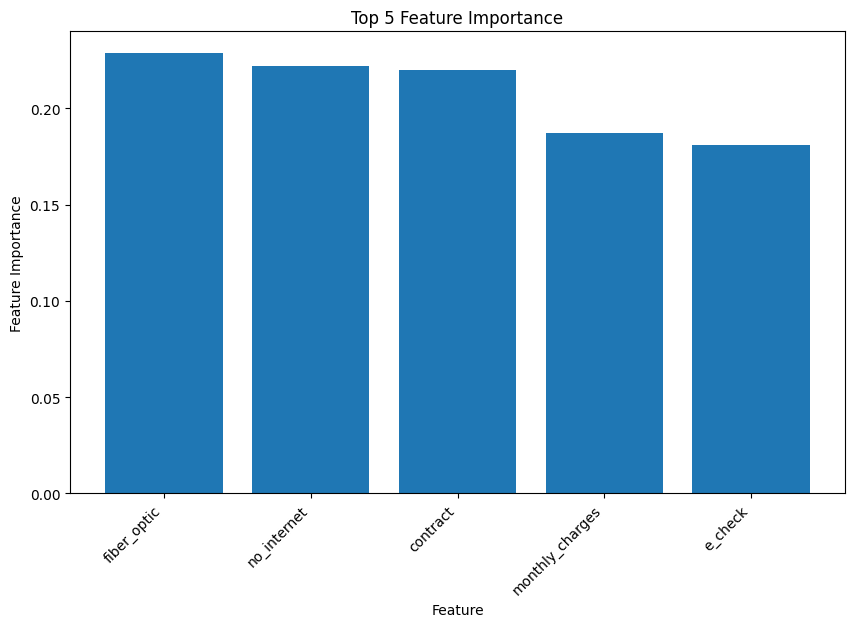

In [83]:
visualizer_mlp.plot_top_features(top_n=5)

Predicted Probabilities:
[0.94923437 0.12952204 0.94462407 ... 0.79868954 0.17610857 0.03624797]


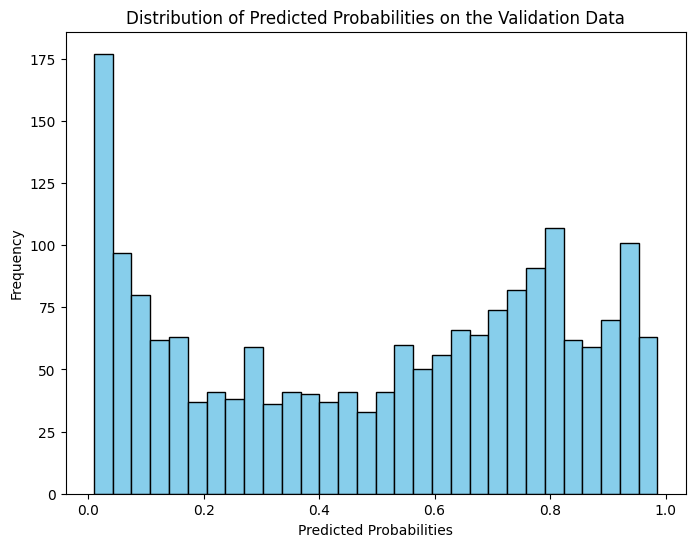

In [84]:
print("Predicted Probabilities:")
print(y_prob_mlp)

# Visualize the distribution of predicted probabilities
plt.figure(figsize=(8, 6))
plt.hist(y_prob_mlp, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Predicted Probabilities on the Validation Data')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.show()

#### Performance metrics and plots for MLP model with test data

In [85]:
# Evaluate the best model on the test set
y_prob_mlp_test = model_mlp.predict(X_test).squeeze()
y_pred_mlp_test = (y_prob_mlp_test > 0.5).astype(int)
accuracy_mlp_test = accuracy_score(y_test, y_pred_mlp_test)
print(f"Accuracy on the test data: {accuracy_mlp_test}")

61/61 [==============================] - 0s 588us/step
Accuracy on the test data: 0.7930497925311203


In [86]:
# Print additional metrics
print("Detailed Classification Report:")
print(classification_report(y_test, y_pred_mlp_test))

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.74      0.78       981
           1       0.76      0.85      0.80       947

    accuracy                           0.79      1928
   macro avg       0.80      0.79      0.79      1928
weighted avg       0.80      0.79      0.79      1928



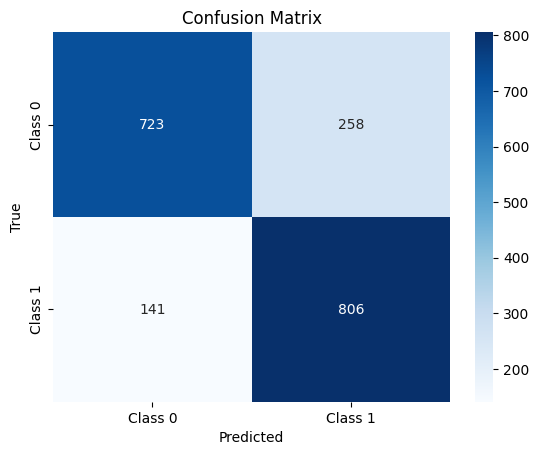

array([[723, 258],
       [141, 806]], dtype=int64)

In [87]:
mlp_cm_plot_test = eval_plots()
mlp_cm_plot_test.plot_confusion_matrix(y_test, y_pred_mlp_test)

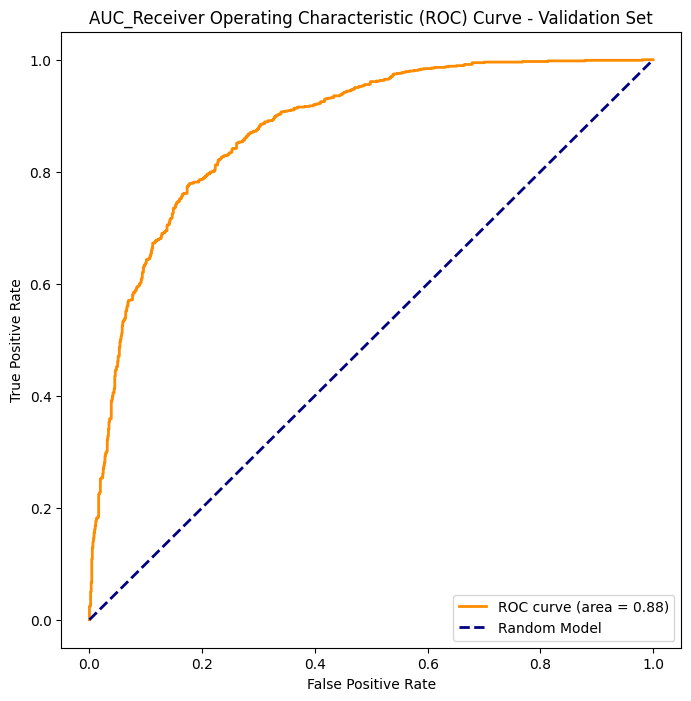

0.8777102863595214

In [88]:
mlp_roc_curve_test = eval_plots()
mlp_roc_curve_test .plot_auc_roc(y_test, y_prob_mlp_test)

0.8592150048851837

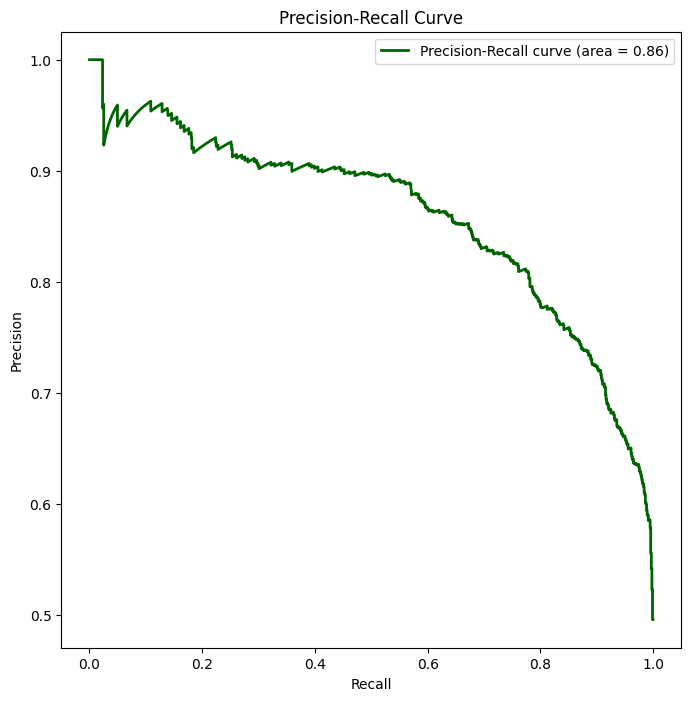

In [89]:
mlp_precision_recall_curve_test = eval_plots()
mlp_precision_recall_curve_test .plot_precision_recall(y_test, y_prob_mlp_test)

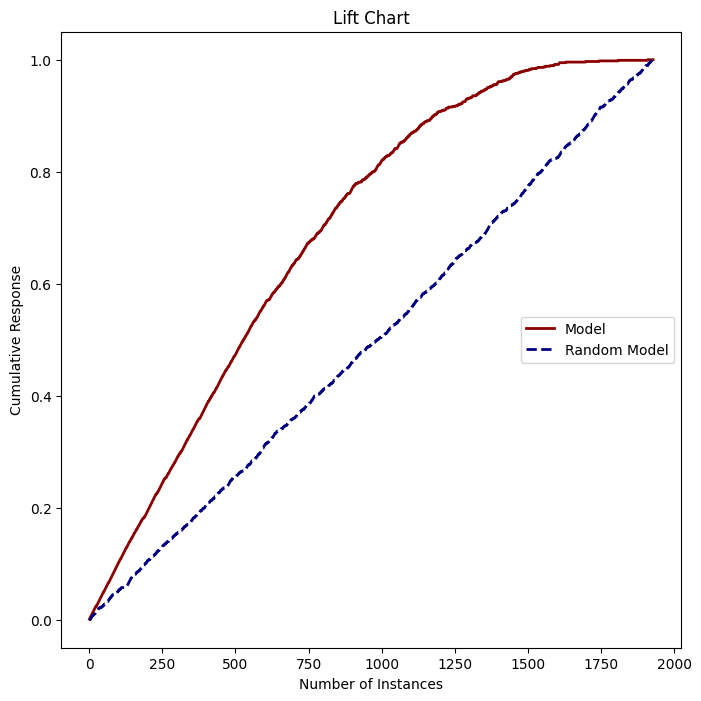

(array([0.00105597, 0.00211193, 0.0031679 , ..., 1.        , 1.        ,
        1.        ]),
 array([0., 0., 0., ..., 1., 1., 1.]))

In [90]:
mlp_lift_chart_test = eval_plots()
mlp_lift_chart_test.plot_lift_chart(y_test, y_prob_mlp_test)

Predicted Probabilities:
[0.8512926  0.6000878  0.7335513  ... 0.48172647 0.9603177  0.16976117]


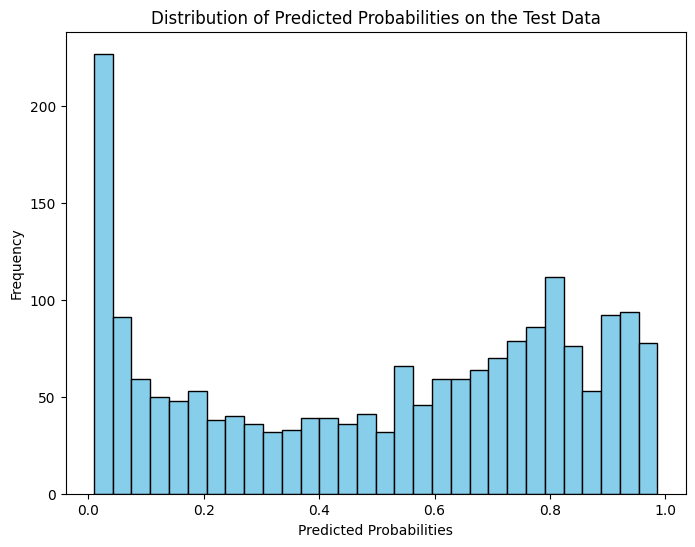

In [91]:
print("Predicted Probabilities:")
print(y_prob_mlp_test)

# Visualize the distribution of predicted probabilities
plt.figure(figsize=(8, 6))
plt.hist(y_prob_mlp_test, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Predicted Probabilities on the Test Data')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.show()

#### Deep Neural Network (DNN)

In [92]:
# Function to create the model
def create_advanced_model(optimizer='adam', dropout_rate=0.5):
    """
    Creates an advanced neural network model with specified hyperparameters.

    Parameters:
    - optimizer: Optimization algorithm for model training (default='adam').
    - dropout_rate: Fraction of input units to drop during training (default=0.5).

    Returns:
    - model: Compiled advanced neural network model.
    """
    model = Sequential()
    
    # Input layer
    model.add(Dense(512, input_dim=X_array.shape[1], activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    # Hidden layers
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    # Additional hidden layers (experiment with architecture)
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# Define hyperparameters to tune
optimizers = ['adam', 'sgd', 'rmsprop']
dropout_rates = [0.3, 0.5, 0.7]

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_accuracy = 0
best_hyperparameters = {}

# Loop through hyperparameters
for optimizer in optimizers:
    for dropout_rate in dropout_rates:
        accuracy_list = []

        # Cross-validation loop
        for train_index, test_index in kf.split(X_train, y_train):
            X_train_cv, X_test_cv = X_train[train_index], X_train[test_index]
            y_train_cv, y_test_cv = y_train[train_index], y_train[test_index]

            model = create_advanced_model(optimizer=optimizer, dropout_rate=dropout_rate)
            model.fit(X_train_cv, y_train_cv, epochs=20, batch_size=64, verbose=0)

            y_pred_prob_cv = model.predict(X_test_cv)
            y_pred_cv = (y_pred_prob_cv > 0.5).astype(int)
            accuracy_cv = accuracy_score(y_test_cv, y_pred_cv)
            accuracy_list.append(accuracy_cv)

        # Calculate average accuracy over cross-validation folds
        average_accuracy = sum(accuracy_list) / len(accuracy_list)

        print(f'Hyperparameters: optimizer={optimizer}, dropout_rate={dropout_rate}')
        print(f'Average accuracy across folds: {average_accuracy * 100:.2f}%\n')

        # Update best hyperparameters if average accuracy improves
        if average_accuracy > best_accuracy:
            best_accuracy = average_accuracy
            best_hyperparameters = {'optimizer': optimizer, 'dropout_rate': dropout_rate}

            # Save the best model for later use
            model_dnn = create_advanced_model(optimizer=optimizer, dropout_rate=dropout_rate)
            model_dnn.fit(X_train, y_train, epochs=20, batch_size=64, verbose=0)

print("Best hyperparameters:", best_hyperparameters)
print("Best average accuracy across folds:", best_accuracy * 100)

# Evaluate the best model on the validation set
y_prob_dnn = model_dnn.predict(X_valid).squeeze()
y_pred_dnn = (y_prob_dnn > 0.5).astype(int)
accuracy_dnn = accuracy_score(y_valid, y_pred_dnn)
print(f"Accuracy on the validation data: {accuracy_dnn}")

37/37 [==============================] - 0s 3ms/step
Hyperparameters: optimizer=adam, dropout_rate=0.3
Average accuracy across folds: 80.08%

37/37 [==============================] - 0s 3ms/step
Hyperparameters: optimizer=adam, dropout_rate=0.5
Average accuracy across folds: 80.03%

37/37 [==============================] - 0s 3ms/step
Hyperparameters: optimizer=adam, dropout_rate=0.7
Average accuracy across folds: 79.48%

37/37 [==============================] - 0s 4ms/step
Hyperparameters: optimizer=sgd, dropout_rate=0.3
Average accuracy across folds: 78.13%

37/37 [==============================] - 0s 3ms/step
Hyperparameters: optimizer=sgd, dropout_rate=0.5
Average accuracy across folds: 75.22%

37/37 [==============================] - 0s 4ms/step
Hyperparameters: optimizer=sgd, dropout_rate=0.7
Average accuracy across folds: 53.13%

37/37 [==============================] - 0s 4ms/step
Hyperparameters: optimizer=rmsprop, dropout_rate=0.3
Average accuracy across folds: 79.72%

37/37 

#### Performance metrics and plots for DNN model with validation data

In [93]:
# Print additional metrics
print("Detailed Classification Report:")
print(classification_report(y_valid, y_pred_dnn))

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.77      0.78       980
           1       0.77      0.79      0.78       948

    accuracy                           0.78      1928
   macro avg       0.78      0.78      0.78      1928
weighted avg       0.78      0.78      0.78      1928



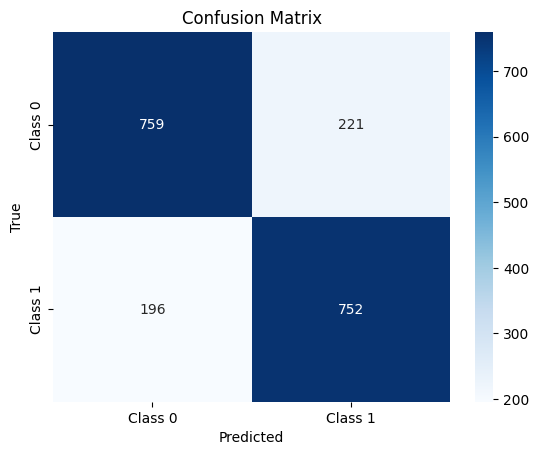

array([[759, 221],
       [196, 752]], dtype=int64)

In [94]:
dnn_cm_plot = eval_plots()
dnn_cm_plot.plot_confusion_matrix(y_valid, y_pred_dnn)

0.8513608106723206

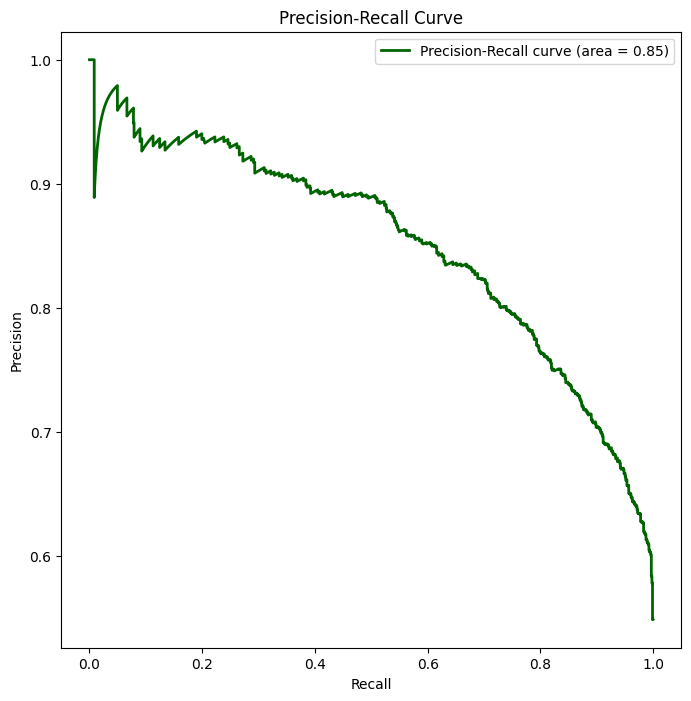

In [95]:
dnn_precision_recall_curve = eval_plots()
dnn_precision_recall_curve .plot_precision_recall(y_valid, y_prob_dnn)

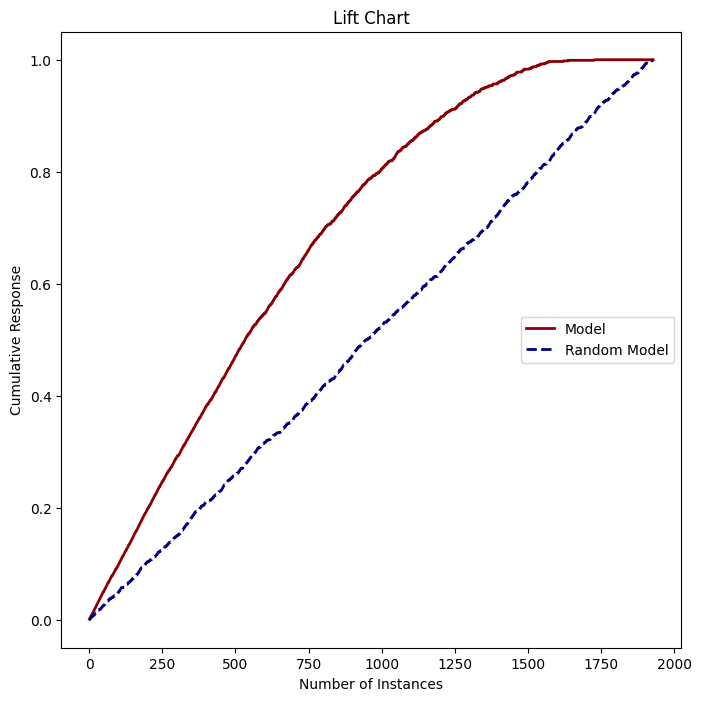

(array([0.00105485, 0.0021097 , 0.00316456, ..., 1.        , 1.        ,
        1.        ]),
 array([0.00000000e+00, 0.00000000e+00, 9.87166831e-04, ...,
        9.99012833e-01, 9.99012833e-01, 1.00000000e+00]))

In [96]:
dnn_lift_chart = eval_plots()
dnn_lift_chart.plot_lift_chart(y_valid, y_prob_dnn)

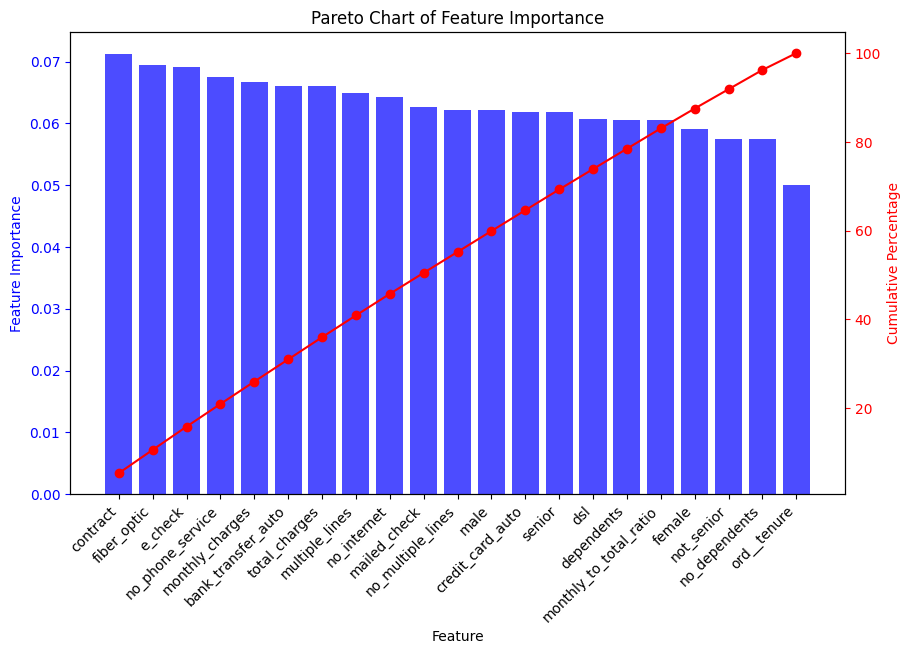

In [97]:
visualizer_dnn = FeatureImportanceVisualizer(model_dnn, X, X.columns)
visualizer_dnn.plot_pareto_chart()

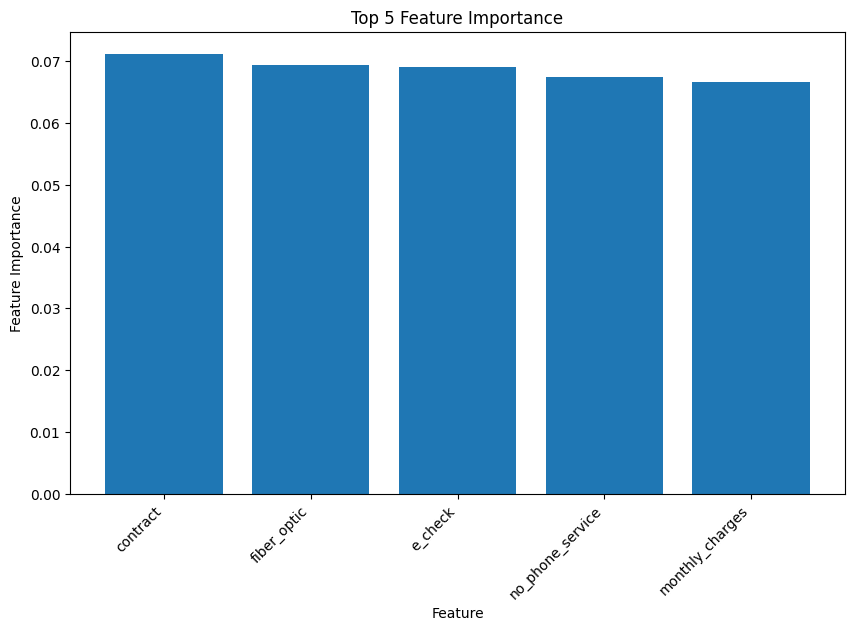

In [98]:
visualizer_dnn.plot_top_features(top_n=5)

Predicted Probabilities:
[0.9715366  0.02289758 0.98291445 ... 0.8092772  0.03914903 0.00148706]


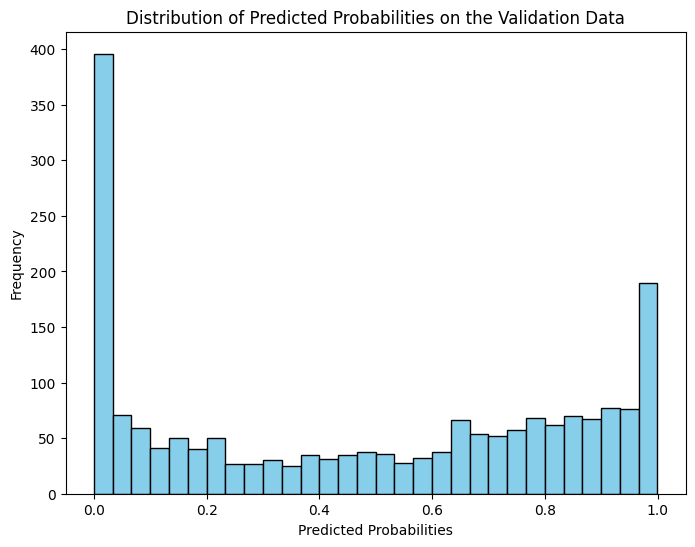

In [99]:
print("Predicted Probabilities:")
print(y_prob_dnn)

# Visualize the distribution of predicted probabilities
plt.figure(figsize=(8, 6))
plt.hist(y_prob_dnn, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Predicted Probabilities on the Validation Data')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.show()

#### Performance metrics and plots for DNN model with test data

In [100]:
# Evaluate the best model on the test set
y_prob_dnn_test = model_dnn.predict(X_test).squeeze()
y_pred_dnn_test = (y_prob_dnn_test > 0.5).astype(int)
accuracy_dnn_test = accuracy_score(y_test, y_pred_dnn_test)
print(f"Accuracy on the test data: {accuracy_dnn_test}")

61/61 [==============================] - 0s 3ms/step
Accuracy on the test data: 0.8013485477178424


In [101]:
# Print additional metrics
print("Detailed Classification Report:")
print(classification_report(y_test, y_pred_dnn_test))

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       981
           1       0.79      0.82      0.80       947

    accuracy                           0.80      1928
   macro avg       0.80      0.80      0.80      1928
weighted avg       0.80      0.80      0.80      1928



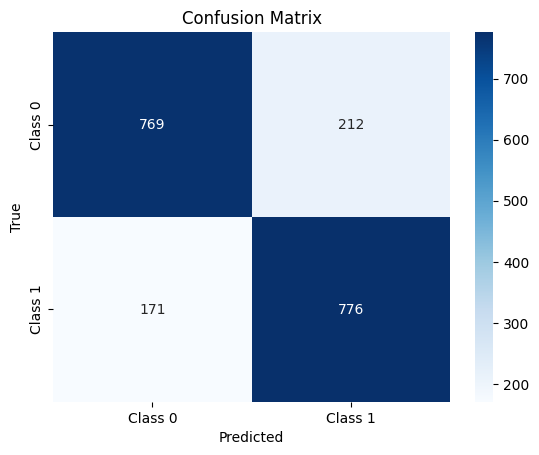

array([[769, 212],
       [171, 776]], dtype=int64)

In [102]:
dnn_cm_plot_test = eval_plots()
dnn_cm_plot_test.plot_confusion_matrix(y_test, y_pred_dnn_test)

0.8572679501023973

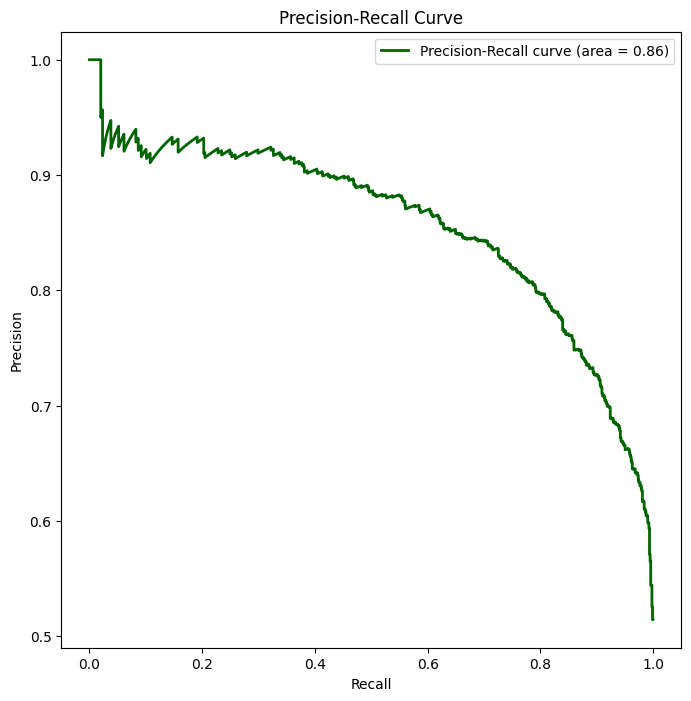

In [103]:
dnn_precision_recall_curve_test = eval_plots()
dnn_precision_recall_curve_test .plot_precision_recall(y_test, y_prob_dnn_test)

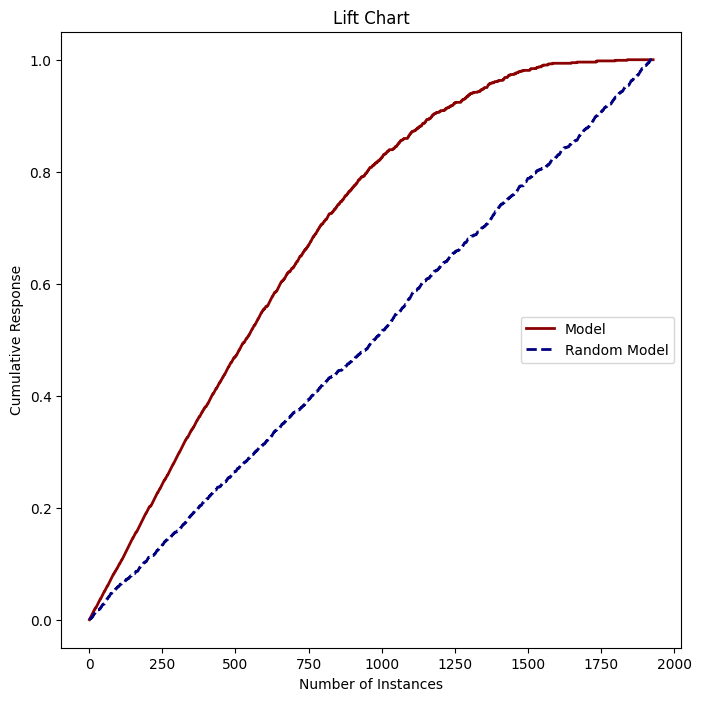

(array([0.00105597, 0.00211193, 0.0031679 , ..., 1.        , 1.        ,
        1.        ]),
 array([0.00104167, 0.00208333, 0.00208333, ..., 1.        , 1.        ,
        1.        ]))

In [104]:
dnn_lift_chart_test = eval_plots()
dnn_lift_chart_test.plot_lift_chart(y_test, y_prob_dnn_test)

Predicted Probabilities:
[0.8941977  0.73102206 0.60297644 ... 0.68817854 0.9927752  0.07035244]


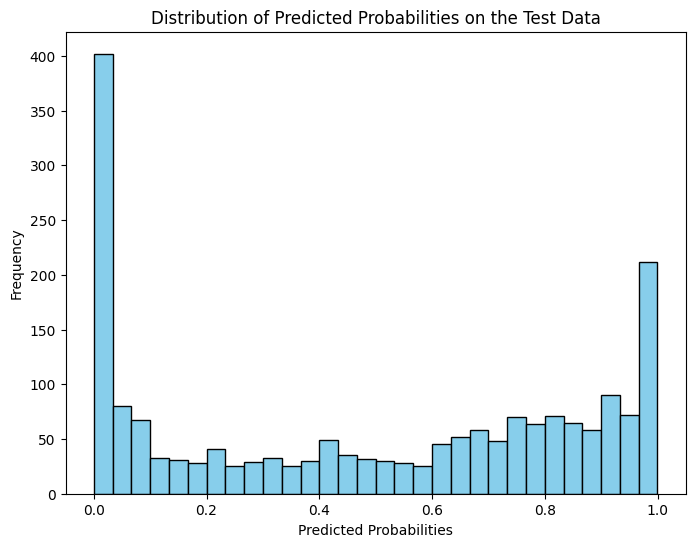

In [105]:
print("Predicted Probabilities:")
print(y_prob_dnn_test)

# Visualize the distribution of predicted probabilities
plt.figure(figsize=(8, 6))
plt.hist(y_prob_dnn_test, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Predicted Probabilities on the Test Data')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.show()

#### LSTM-Long Short-Term Memory

Epoch 1/100
145/145 [==============================] - 2s 7ms/step - loss: 0.6795 - accuracy: 0.6248 - val_loss: 0.6400 - val_accuracy: 0.7226
Epoch 2/100
145/145 [==============================] - 1s 5ms/step - loss: 0.6068 - accuracy: 0.6974 - val_loss: 0.5731 - val_accuracy: 0.7208
Epoch 3/100
145/145 [==============================] - 1s 5ms/step - loss: 0.5777 - accuracy: 0.7050 - val_loss: 0.5508 - val_accuracy: 0.7373
Epoch 4/100
145/145 [==============================] - 1s 5ms/step - loss: 0.5529 - accuracy: 0.7247 - val_loss: 0.5231 - val_accuracy: 0.7640
Epoch 5/100
145/145 [==============================] - 1s 5ms/step - loss: 0.5331 - accuracy: 0.7441 - val_loss: 0.5031 - val_accuracy: 0.7701
Epoch 6/100
145/145 [==============================] - 1s 5ms/step - loss: 0.5214 - accuracy: 0.7556 - val_loss: 0.4878 - val_accuracy: 0.7761
Epoch 7/100
145/145 [==============================] - 1s 5ms/step - loss: 0.5071 - accuracy: 0.7623 - val_loss: 0.4793 - val_accuracy: 0.7908

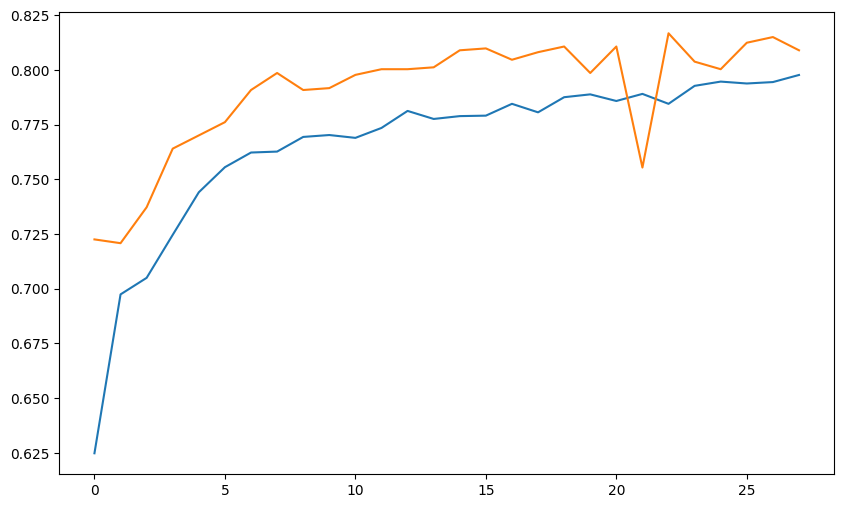

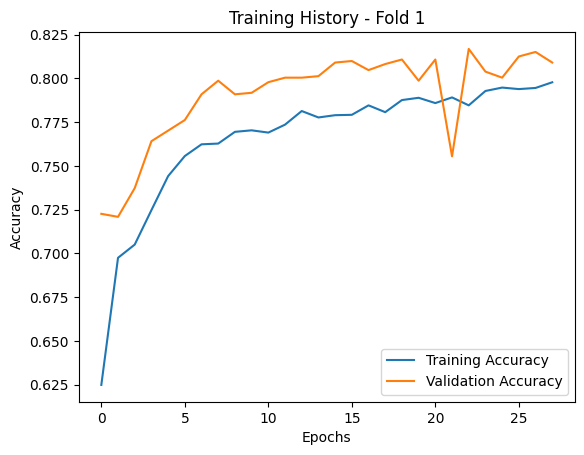

Epoch 1/100
145/145 [==============================] - 2s 7ms/step - loss: 0.6579 - accuracy: 0.6456 - val_loss: 0.6286 - val_accuracy: 0.6724
Epoch 2/100
145/145 [==============================] - 1s 5ms/step - loss: 0.5987 - accuracy: 0.6942 - val_loss: 0.5994 - val_accuracy: 0.6802
Epoch 3/100
145/145 [==============================] - 1s 5ms/step - loss: 0.5839 - accuracy: 0.6940 - val_loss: 0.5911 - val_accuracy: 0.6837
Epoch 4/100
145/145 [==============================] - 1s 4ms/step - loss: 0.5744 - accuracy: 0.7024 - val_loss: 0.5835 - val_accuracy: 0.6871
Epoch 5/100
145/145 [==============================] - 1s 4ms/step - loss: 0.5645 - accuracy: 0.7076 - val_loss: 0.5742 - val_accuracy: 0.6949
Epoch 6/100
145/145 [==============================] - 1s 4ms/step - loss: 0.5526 - accuracy: 0.7145 - val_loss: 0.5600 - val_accuracy: 0.7027
Epoch 7/100
145/145 [==============================] - 1s 4ms/step - loss: 0.5341 - accuracy: 0.7355 - val_loss: 0.5384 - val_accuracy: 0.7312

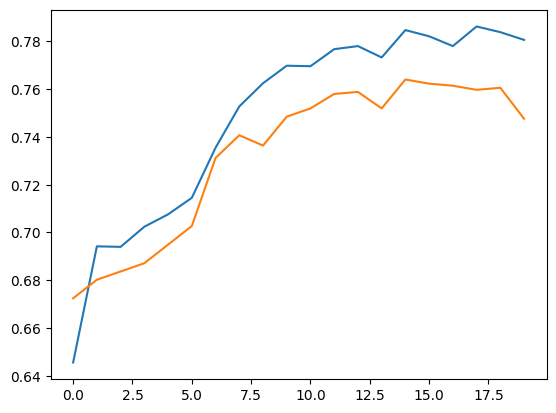

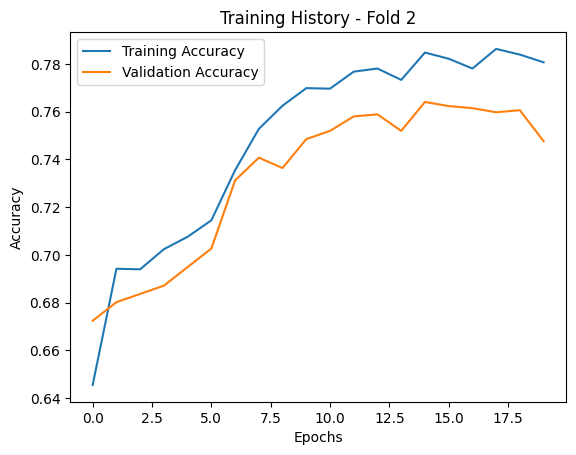

Epoch 1/100
145/145 [==============================] - 2s 7ms/step - loss: 0.6854 - accuracy: 0.5336 - val_loss: 0.6475 - val_accuracy: 0.6880
Epoch 2/100
145/145 [==============================] - 1s 4ms/step - loss: 0.6140 - accuracy: 0.6907 - val_loss: 0.5991 - val_accuracy: 0.6828
Epoch 3/100
145/145 [==============================] - 1s 4ms/step - loss: 0.5915 - accuracy: 0.6961 - val_loss: 0.5849 - val_accuracy: 0.6863
Epoch 4/100
145/145 [==============================] - 1s 4ms/step - loss: 0.5855 - accuracy: 0.6940 - val_loss: 0.5834 - val_accuracy: 0.6889
Epoch 5/100
145/145 [==============================] - 1s 4ms/step - loss: 0.5790 - accuracy: 0.7020 - val_loss: 0.5715 - val_accuracy: 0.6966
Epoch 6/100
145/145 [==============================] - 1s 4ms/step - loss: 0.5691 - accuracy: 0.7069 - val_loss: 0.5598 - val_accuracy: 0.7113
Epoch 7/100
145/145 [==============================] - 1s 4ms/step - loss: 0.5601 - accuracy: 0.7154 - val_loss: 0.5506 - val_accuracy: 0.7053

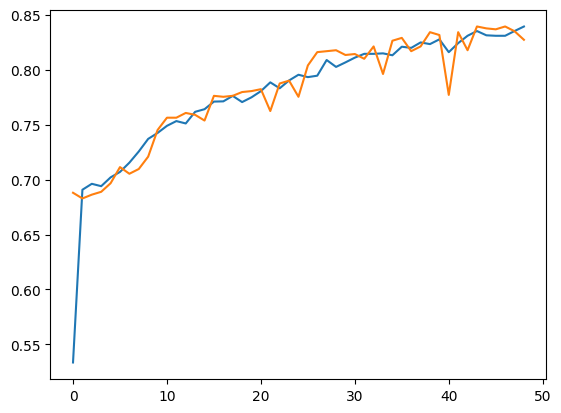

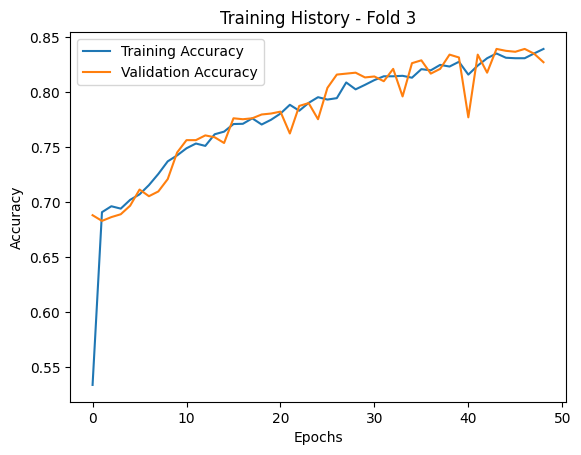

Epoch 1/100
145/145 [==============================] - 2s 6ms/step - loss: 0.6629 - accuracy: 0.6555 - val_loss: 0.6146 - val_accuracy: 0.6958
Epoch 2/100
145/145 [==============================] - 1s 4ms/step - loss: 0.6027 - accuracy: 0.6866 - val_loss: 0.6069 - val_accuracy: 0.6750
Epoch 3/100
145/145 [==============================] - 1s 4ms/step - loss: 0.5943 - accuracy: 0.6946 - val_loss: 0.5885 - val_accuracy: 0.7010
Epoch 4/100
145/145 [==============================] - 1s 4ms/step - loss: 0.5836 - accuracy: 0.6998 - val_loss: 0.5768 - val_accuracy: 0.7139
Epoch 5/100
145/145 [==============================] - 1s 4ms/step - loss: 0.5741 - accuracy: 0.7106 - val_loss: 0.5635 - val_accuracy: 0.7286
Epoch 6/100
145/145 [==============================] - 1s 4ms/step - loss: 0.5630 - accuracy: 0.7173 - val_loss: 0.5494 - val_accuracy: 0.7321
Epoch 7/100
145/145 [==============================] - 1s 4ms/step - loss: 0.5436 - accuracy: 0.7396 - val_loss: 0.5357 - val_accuracy: 0.7606

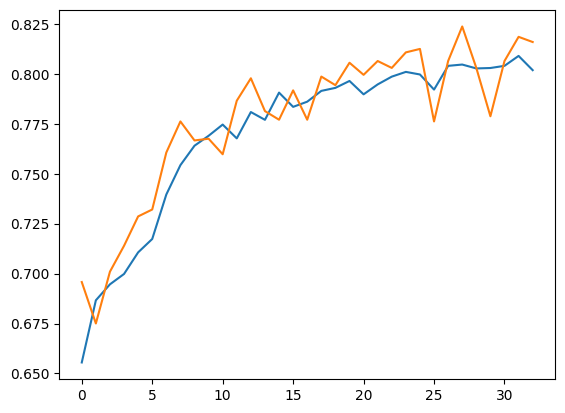

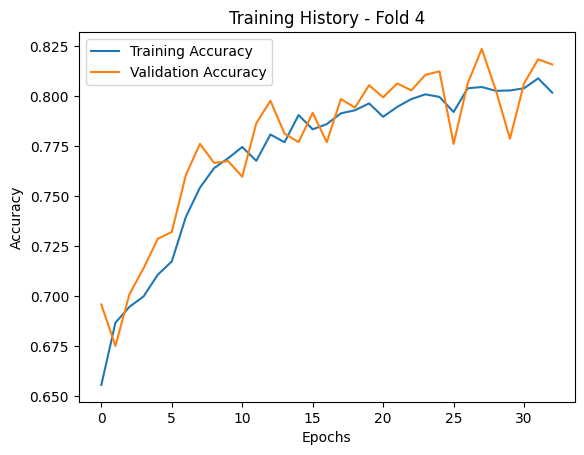

Epoch 1/100
145/145 [==============================] - 2s 6ms/step - loss: 0.6568 - accuracy: 0.6519 - val_loss: 0.6150 - val_accuracy: 0.6721
Epoch 2/100
145/145 [==============================] - 1s 5ms/step - loss: 0.5961 - accuracy: 0.6921 - val_loss: 0.5818 - val_accuracy: 0.6938
Epoch 3/100
145/145 [==============================] - 1s 5ms/step - loss: 0.5773 - accuracy: 0.7035 - val_loss: 0.5687 - val_accuracy: 0.7016
Epoch 4/100
145/145 [==============================] - 1s 5ms/step - loss: 0.5642 - accuracy: 0.7167 - val_loss: 0.5511 - val_accuracy: 0.7206
Epoch 5/100
145/145 [==============================] - 1s 5ms/step - loss: 0.5485 - accuracy: 0.7284 - val_loss: 0.5539 - val_accuracy: 0.7197
Epoch 6/100
145/145 [==============================] - 1s 5ms/step - loss: 0.5303 - accuracy: 0.7435 - val_loss: 0.5331 - val_accuracy: 0.7379
Epoch 7/100
145/145 [==============================] - 1s 5ms/step - loss: 0.5212 - accuracy: 0.7558 - val_loss: 0.5270 - val_accuracy: 0.7353

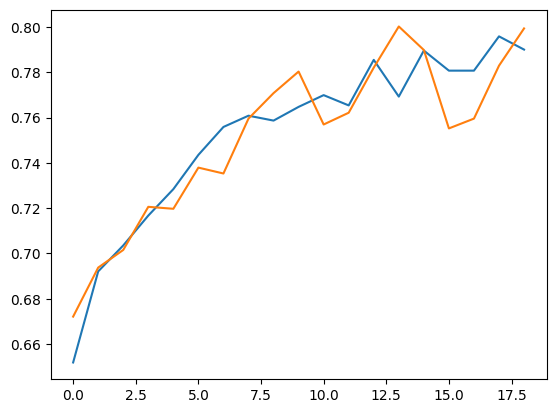

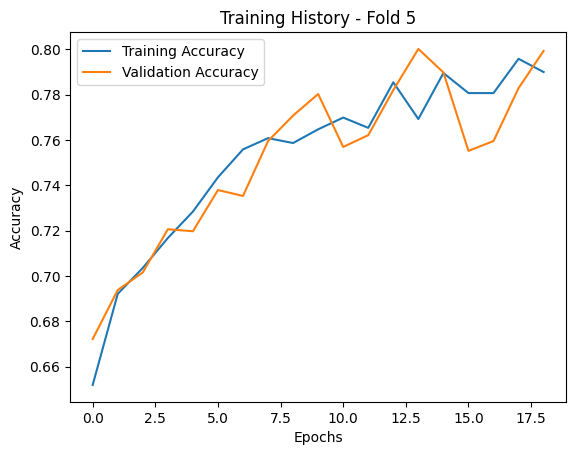

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


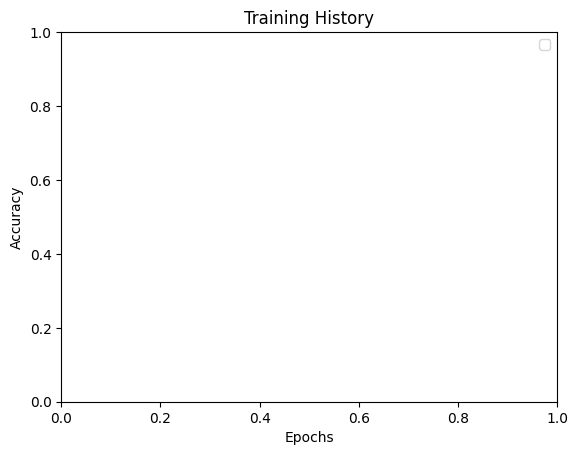

61/61 [==============================] - 0s 1ms/step
Accuracy om validation data: 0.7935684647302904


In [106]:
# Define the LSTM model with early stopping
def create_lstm_model(units=10):
    """
    Creates an LSTM (Long Short-Term Memory) neural network model with specified hyperparameters.

    Parameters:
    - units: Positive integer, the dimensionality of the output space (default=10).

    Returns:
    - model: Compiled LSTM neural network model.
    """
    model = Sequential()
    model.add(LSTM(units, input_shape=(X_train.shape[1], 1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Wrap the Keras model with the KerasClassifier
keras_model = KerasClassifier(build_fn=create_lstm_model, epochs=100, batch_size=32, verbose=0)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

# Define cross-validation parameters
n_splits = 5  # you can adjust the number of splits
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Create a figure for plotting
plt.figure(figsize=(10, 6))

# Perform cross-validation
for fold_idx, (train_index, valid_index) in enumerate(skf.split(X_train, y_train), 1):
    X_train_cv, X_valid_cv = X_train[train_index], X_train[valid_index]
    y_train_cv, y_valid_cv = y_train[train_index], y_train[valid_index]

    # Create the LSTM model
    model_lstm = create_lstm_model()

    # Train the model with early stopping
    history = model_lstm.fit(X_train_cv, y_train_cv, epochs=100, batch_size=32,
                        validation_data=(X_valid_cv, y_valid_cv), callbacks=[early_stopping]) # early stopping will ensure selecting the model with best hyperparameters.

    # Plot the training history
    plt.plot(history.history['accuracy'], label=f'Training Fold {fold_idx}')
    plt.plot(history.history['val_accuracy'], label=f'Validation Fold {fold_idx}')

    # Display the training history for each fold
    plt.figure()
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title(f'Training History - Fold {fold_idx}')
    plt.legend()
    plt.show()

# Display the plot
plt.title('Training History')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate the model on the validation set
y_prob_lstm = model_lstm.predict(X_valid)
y_pred_lstm = (y_prob_lstm > 0.5).astype(int)
accuracy_lstm = accuracy_score(y_valid, y_pred_lstm)
print(f"Accuracy om validation data: {accuracy_lstm}")

#### Performance metrics and plots for LSTM model with validation data

In [107]:
# Print additional metrics
print("Detailed Classification Report:")
print(classification_report(y_valid, y_pred_lstm))

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.76      0.79       980
           1       0.77      0.83      0.80       948

    accuracy                           0.79      1928
   macro avg       0.80      0.79      0.79      1928
weighted avg       0.80      0.79      0.79      1928



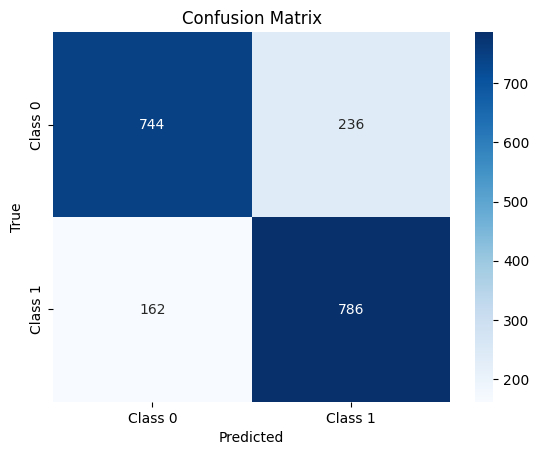

array([[744, 236],
       [162, 786]], dtype=int64)

In [108]:
lstm_cm_plot = eval_plots()
lstm_cm_plot.plot_confusion_matrix(y_valid, y_pred_lstm)

0.7947625730798484

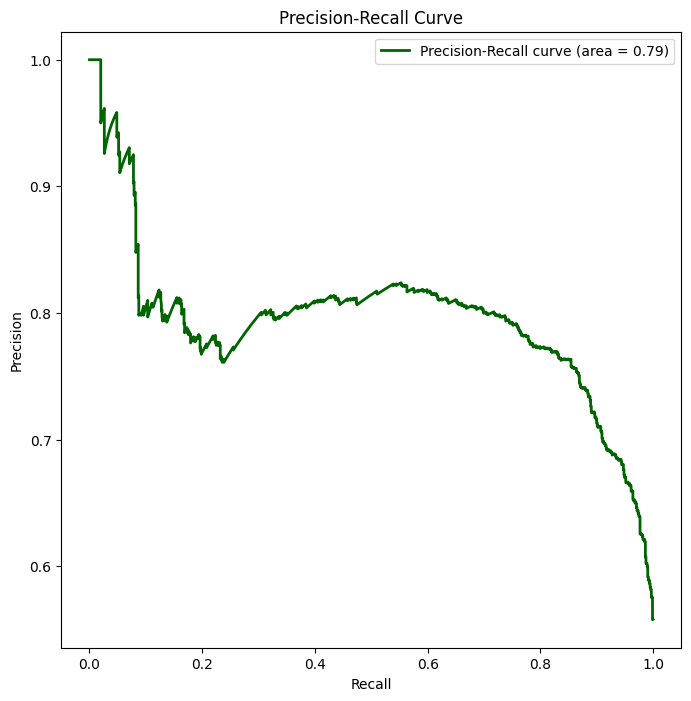

In [109]:
lstm_precision_recall_curve = eval_plots()
lstm_precision_recall_curve.plot_precision_recall(y_valid, y_prob_lstm)

Predicted Probabilities:
[[0.8724355 ]
 [0.20590568]
 [0.83197594]
 ...
 [0.55890685]
 [0.07341962]
 [0.05409293]]


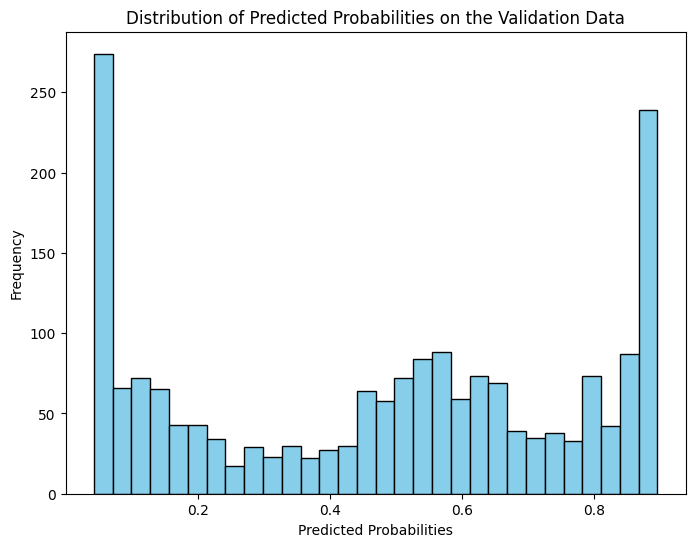

In [110]:
print("Predicted Probabilities:")
print(y_prob_lstm)

# Visualize the distribution of predicted probabilities
plt.figure(figsize=(8, 6))
plt.hist(y_prob_lstm, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Predicted Probabilities on the Validation Data')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.show()

#### Performance metrics and plots for LSTM model with test data

In [111]:
# Evaluate the model on the test set
y_prob_lstm_test = model_lstm.predict(X_test)
y_pred_lstm_test = (y_prob_lstm_test > 0.5).astype(int)
accuracy_lstm_test = accuracy_score(y_test, y_pred_lstm_test)
print(f"Accuracy on the test data: {accuracy_lstm_test}")

61/61 [==============================] - 0s 1ms/step
Accuracy on the test data: 0.7987551867219918


In [112]:
# Print additional metrics
print("Detailed Classification Report:")
print(classification_report(y_test, y_pred_lstm_test))

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.77      0.80       981
           1       0.78      0.83      0.80       947

    accuracy                           0.80      1928
   macro avg       0.80      0.80      0.80      1928
weighted avg       0.80      0.80      0.80      1928



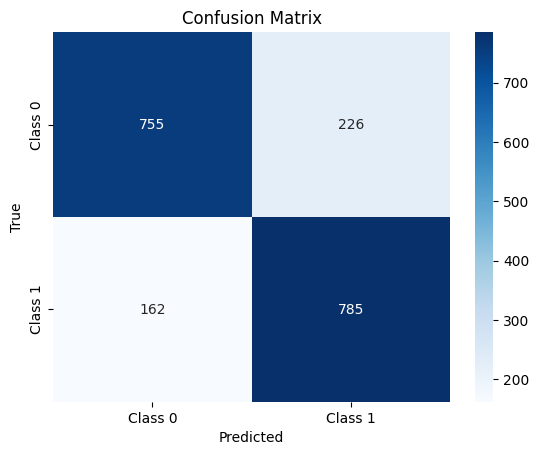

array([[755, 226],
       [162, 785]], dtype=int64)

In [113]:
lstm_cm_plot_test = eval_plots()
lstm_cm_plot_test.plot_confusion_matrix(y_test, y_pred_lstm_test)

0.8227971083447145

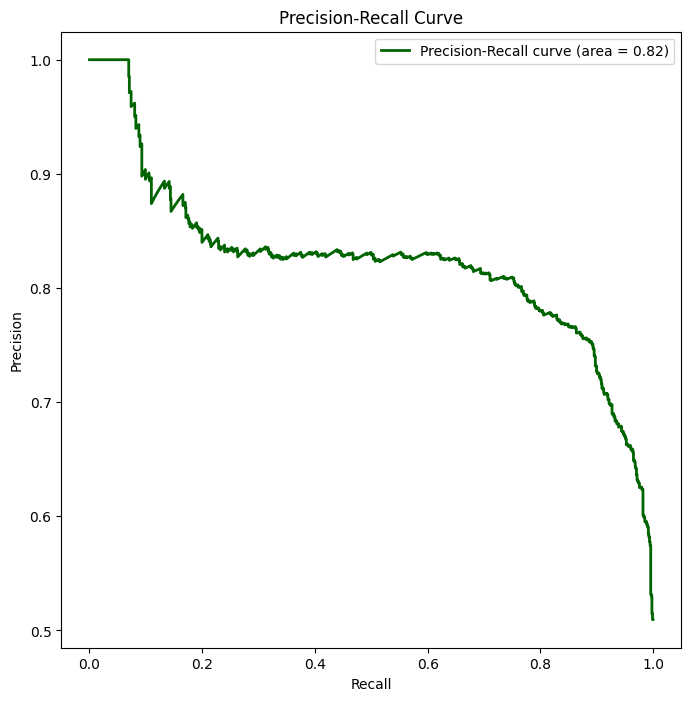

In [114]:
lstm_precision_recall_curve_test = eval_plots()
lstm_precision_recall_curve_test.plot_precision_recall(y_test, y_prob_lstm_test)

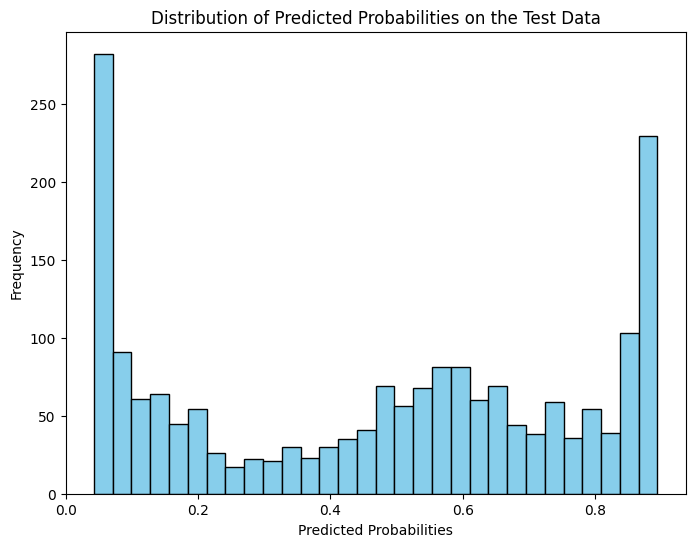

In [115]:
# Visualize the distribution of predicted probabilities

plt.figure(figsize=(8, 6))
plt.hist(y_prob_lstm_test, bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Predicted Probabilities on the Test Data')
plt.xlabel('Predicted Probabilities')
plt.ylabel('Frequency')
plt.show()

## Model Evaluation

We will develop a class encapsulating performance metrics and plots for the evaluation of our models. We will evaluate the models both on validation and test data to assess the generalization of the models on completely unseen data, as the test data was not used at any stages of the model development beginning from exploratory data analysis to avoid any information leakage.  

In [116]:
class ModelEvaluator:
    def __init__(self, models, X, y, dataset_name):
        self.models = models
        self.X = X
        self.y = y
        self.dataset_name = dataset_name

    def calculate_metrics(self, model, X, y, metric_func):
        """
        Calculates a specified classification metric for a given model on data.

        Args:
            model (object): Trained machine learning model.
            X (numpy array): Features.
            y (numpy array): Labels.
            metric_func (function): Classification metric function from scikit-learn.

        Returns:
            float: The computed value of the specified metric.
        """
        y_prob = model.predict(X, verbose=0)
        y_pred = (y_prob > 0.5).astype(int)
        score = metric_func(y, y_pred)
        return score

    def compare_metrics(self):
        """
        Compares the performance of multiple models on data and prints the results in a table.
        """
        # Add a title reflecting the dataset used
        print(f"\nComparison of Metrics on the {self.dataset_name} Data\n")

        metrics = {'Accuracy': accuracy_score, 'Recall': recall_score, 'Precision': precision_score, 'F1 Score': f1_score}

        for metric_name, metric_func in metrics.items():
            # Create a list of tuples (name, score) for each model
            scores = [(name, self.calculate_metrics(model, self.X, self.y, metric_func)) for name, model in self.models.items()]

            # Sort the list in descending order based on the scores
            scores.sort(key=lambda x: x[1], reverse=True)

            # Create a PrettyTable
            table = PrettyTable()
            table.field_names = ['\033[1mModel\033[0m', f'\033[1m{metric_name}\033[0m']

            # Add data to the table
            for name, score in scores:
                table.add_row([name, f'{score:.2f}'])

            # Print the formatted table
            print(table)

    def plot_metrics(self):
        """
        Compares the performance of multiple models on data for key metrics and visualizes the results in a grouped bar chart.
        """
        metrics = {
            'Accuracy': accuracy_score,
            'Recall': recall_score,
            'Precision': precision_score,
            'F1 Score': f1_score
        }

        # Define colors for each metric
        colors = {
            'Accuracy': '#7f8c8d',
            'Recall': '#c0392b',
            'Precision': '#c0c5c5',
            'F1 Score': '#e57373'
        }

        # Create a grouped bar plot
        bar_width = 0.2
        bar_positions = np.arange(len(self.models))
        plt.figure(figsize=(12, 6))

        # Create a mapping between model names and their original order
        model_order = {name: i for i, name in enumerate(self.models.keys())}

        for i, (metric_name, metric_func) in enumerate(metrics.items()):
            # Create a list of tuples (name, score) for each model
            scores = [(name, self.calculate_metrics(model, self.X, self.y, metric_func)) for name, model in self.models.items()]

            # Sort the list based on the original order
            scores.sort(key=lambda x: model_order[x[0]])

            # Create lists for plotting
            model_names, metric_scores = zip(*scores)

            # Adjust bar positions for grouping
            offset = (i - 1.5) * bar_width
            bars = plt.bar(
                bar_positions + offset,
                metric_scores,
                bar_width,
                label=f'{metric_name}',
                color=colors[metric_name]
            )

            # Add annotations with percentage values
            for bar, score in zip(bars, metric_scores):
                plt.text(
                    bar.get_x() + bar.get_width() / 2,
                    bar.get_height() + 0.01,
                    f'{score:.2%}',
                    ha='center',
                    va='bottom'
                )

        plt.title(f"Comparative Performance of Models on {self.dataset_name} Data: Grouped Bar Chart")
        plt.xlabel('Model')
        plt.ylabel('Score')
        plt.xticks(bar_positions, model_names)
        # plt.legend()
        # plt.legend(loc='center right')
        plt.legend(loc='center right', bbox_to_anchor=(1, 0.75))
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()


In [117]:
# Creating a dictionary of the models 
models = {
    'Feed Forward Neural Network': model_fnn,
    'Multi-Layer Perception': model_mlp,
    'Deep Neural Network': model_dnn,
    'LSTM': model_lstm
}

### Evaluating the Performance of the Models on Validation Data

In [118]:
# Creating an instance of the class
evaluator_valid = ModelEvaluator(models, X_valid, y_valid,dataset_name="Validation")

In [119]:
# Calling the method for comparative tables
evaluator_valid.compare_metrics()


Comparison of Metrics on the Validation Data

+-----------------------------+----------+
|            Model            | Accuracy |
+-----------------------------+----------+
|             LSTM            |   0.79   |
|    Multi-Layer Perception   |   0.79   |
| Feed Forward Neural Network |   0.79   |
|     Deep Neural Network     |   0.78   |
+-----------------------------+----------+
+-----------------------------+--------+
|            Model            | Recall |
+-----------------------------+--------+
| Feed Forward Neural Network |  0.87  |
|    Multi-Layer Perception   |  0.84  |
|             LSTM            |  0.83  |
|     Deep Neural Network     |  0.79  |
+-----------------------------+--------+
+-----------------------------+-----------+
|            Model            | Precision |
+-----------------------------+-----------+
|     Deep Neural Network     |    0.77   |
|             LSTM            |    0.77   |
|    Multi-Layer Perception   |    0.76   |
| Feed Forward Ne

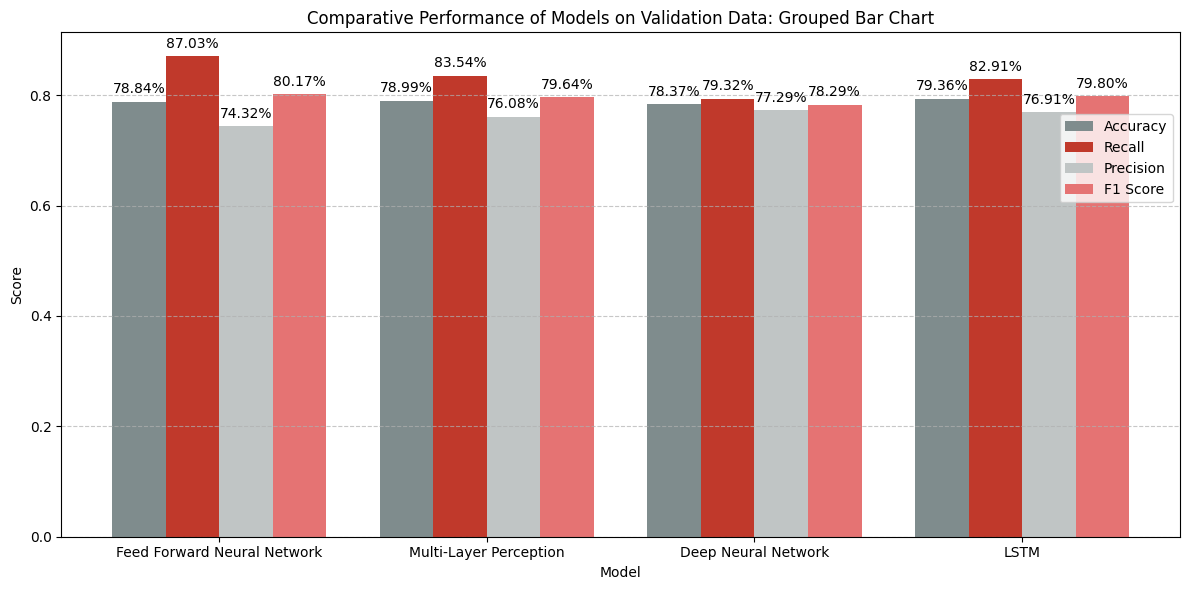

In [120]:
# Calling the method for grouped bar chart
evaluator_valid.plot_metrics()

Based on validation data, LSTM has the highest accuracy indicating the proportion of correctly classifying the observations out of the total. However, accuracy alone should not be the deciding factor when data is highly imbalanced. 

Deep Neural Network has the highest recall at 0.87, suggesting it is effective at capturing most of the actual churn classes. A high recall is valuable when the cost of missing a churn (false negatives) is considered high, and the goal is to identify as many churn instances as possible.

LSTM has the highest precision at 0.84, implying that when it predicts a churn, it is more likely to be correct. 
High precision is valuable when the cost of false positives is hig (i.e., predicting a non-churn as churn)h, and the goal is to minimize the number of incorrect churn predictions

LSTM also has the highest F1 Score at 0.83, which balances precision and recall. It's a useful metric when there is an uneven class distribution.
F1 Score considers both false positives and false negatives and is suitable whenweu want a balance between precision and recall

Considering the objective of our project to reduce churn, the cost of missing a churn is high for us. In this scenario, prioritizing models with high recall like Deep Neural Network might be beneficial.

If the cost of making incorrect predictionswass a significant concern, considering precision-focused models like LSTM might be appropriate
.However, based on validation data, 
LSTM seems to strike a good balance between precision, recall, and overall accura with a high F1 scorec

We will now analyze the performance of our models using the test data to choose our final model.y...

### Evaluating the Performance of the Models on Test Data

In [121]:
# Creating an instance of the class
evaluator_test = ModelEvaluator(models, X_test, y_test, dataset_name="Test")

In [122]:
# Calling the method for comparative tables
evaluator_test.compare_metrics()


Comparison of Metrics on the Test Data

+-----------------------------+----------+
|            Model            | Accuracy |
+-----------------------------+----------+
|     Deep Neural Network     |   0.80   |
|             LSTM            |   0.80   |
|    Multi-Layer Perception   |   0.79   |
| Feed Forward Neural Network |   0.79   |
+-----------------------------+----------+
+-----------------------------+--------+
|            Model            | Recall |
+-----------------------------+--------+
| Feed Forward Neural Network |  0.88  |
|    Multi-Layer Perception   |  0.85  |
|             LSTM            |  0.83  |
|     Deep Neural Network     |  0.82  |
+-----------------------------+--------+
+-----------------------------+-----------+
|            Model            | Precision |
+-----------------------------+-----------+
|     Deep Neural Network     |    0.79   |
|             LSTM            |    0.78   |
|    Multi-Layer Perception   |    0.76   |
| Feed Forward Neural N

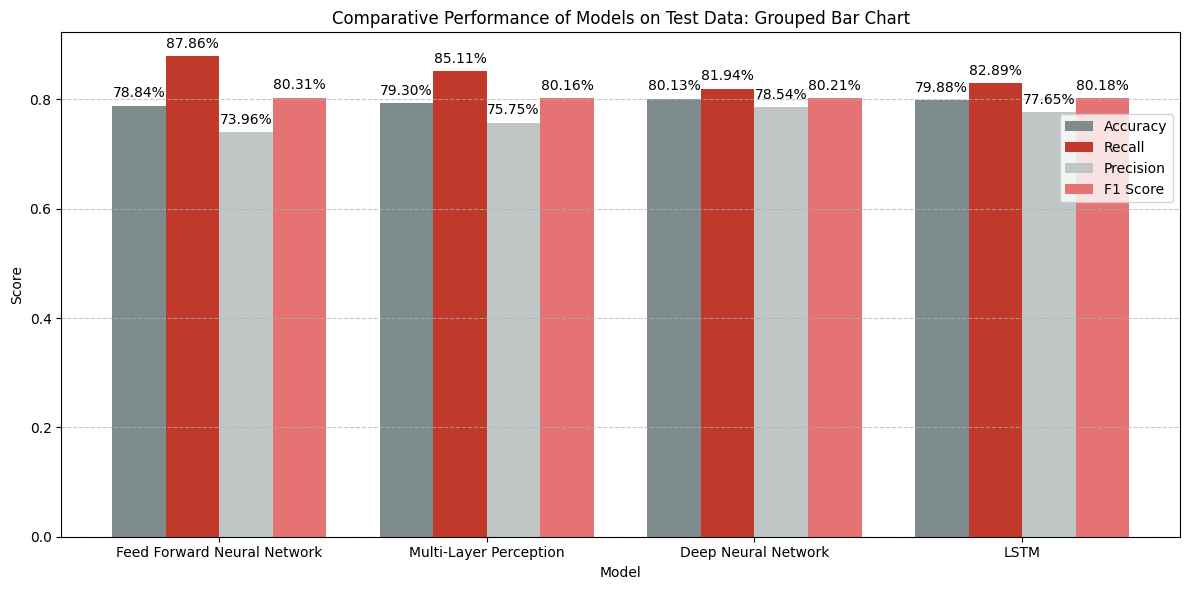

In [123]:
# Calling the method for grouped bar chart
evaluator_test.plot_metrics()

Based on the test data, LSTM maintains a high accuracy at 0.84, suggesting it performs well in terms of overall correct predictions on the test set.
All models, including Multi-Layer Perception, Feed Forward Neural Network, and Deep Neural Network, exhibit comparable accuracy.

Deep Neural Network continues to show the highest recall at 0.88, indicating its effectiveness in capturing the most actual churn instances.
LSTM follows closely with a recall of 0.83, suggesting it is also proficient at identifying churn cases

LSTM retains the highest precision at 0.83, emphasizing its capability to make accurate positive predictions. 
Multi-Layer Perception and Feed Forward Neural Network demonstrate slightly lower precision, while Deep Neural Network has the lowest precision at 0.74.
LSTM maintains the highest F1 Score at 0.83, reflecting a good balance between precision and recall on the test data. 
Deep Neural Network follows closely with an F1 Score of 0.81..


## Conclusion

The performance of the models on the test data aligns with their performance on the validation data, which is a positive sign of generalization.
LSTM continues to perform consistently well across multiple metrics, making it a robust choice for customer churn prediction.
Deep Neural Network exhibits high recall, making it suitable for scenarios where capturing as many churn instances as possible is crucial.

Depending on the specific business context, the choice of the best model might vary. If minimizing false negatives (missed churn instances) is crucial, a model with high recall, such as Deep Neural Network, could be preferred. If a balance between precision and recall is desired, LSTM remains a strong candidate.

Higher false positives also have some costs- both monetary and non-monetary. Promotions aimed at loyal customers might incur costs while intervening with the customers who tend not to churn. While achieving high recall is our main objective, our secondary objective should also be to minimize false positives (i.e. achieving higher precision). High recall, a reasonable level of precision, and a higher balance achieved by a higher f1 score should be the ultimate goal.

Considering all the factors, I would propose LSTM as our champion model for customer churn prediction.

## Next Steps

While the Telco customer churn data set is a descent data set, it needs more features to further improve the modelling.

Regency, Frequency, and Monetary (RFM) - Analysing how recently and how often a customer has interacted with the business and the monetary value of a customer's transactions will be good additions.

Having time-related features can help extract the time of the day, day of the week, month, season when customers are more active, and the duration since the last customer interaction or transaction. Time-related features are handled very well by models like LSTM- our champion model for this project.

Having features related to customer engagement such as the number of logins, clicks, or interactions within a specified period and the average time spent on the platform can help improve the modelling. 

Features related to the geographic location of the customers, and income if available should also help.

Features related to customer complaints or support tickets, resolution of the issues, and customer rating of the company services will be helpful.

If the business has a loyalty programme, including features related to loyalty points, membership duration will be useful.

Macroeconomic conditions also influence customer behaviour. During the economic contraction periods, customers may look for affordable alternatives.

Technological advancement and the company's adaptability to innovative technologies can embrace new customers as well as retain existing customers. Being at the forefront of technology can also reduce costs and may help in competitive pricing to retain customers. 